In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from astropy.time import Time
from gaussian_process_example import *

sns.set_style('whitegrid')


df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.t < 25]
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
filters = ['ztfg', 'ztfr', 'ztfi']

savefigs = True

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
0,57983.231000,385.374906,440.341788,404.940209,29.250027,17.182907,24.797305,Kilonova,AT2017gfo,57983.231000,...,0.082408,17.381523,-15.832157,0.066487,17.290525,-15.923154,0.042367,0.000000,n,y
1,57983.239778,382.559484,438.232033,402.502588,28.789575,16.890215,24.361032,Kilonova,AT2017gfo,57983.231000,...,0.081707,17.388078,-15.825601,0.065713,17.295740,-15.917940,0.041846,0.008778,n,y
2,57983.248556,379.738177,436.119876,400.065220,28.332873,16.606597,23.927709,Kilonova,AT2017gfo,57983.231000,...,0.081009,17.394673,-15.819007,0.064937,17.300985,-15.912694,0.041343,0.017556,n,y
3,57983.257333,376.910979,434.005567,397.628148,27.879986,16.332054,23.497397,Kilonova,AT2017gfo,57983.231000,...,0.080312,17.401307,-15.812372,0.064160,17.306262,-15.907418,0.040857,0.026333,n,y
4,57983.266111,374.077886,431.889351,395.191413,27.430981,16.066587,23.070161,Kilonova,AT2017gfo,57983.231000,...,0.079617,17.407981,-15.805698,0.063382,17.311569,-15.902111,0.040390,0.035111,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38853,60652.513689,33.493383,NaN,40.961798,3.488673,NaN,5.252959,IIb,ZTF24abvevzs,60646.432303,...,0.113090,19.869052,-16.140503,0.139235,NaN,NaN,NaN,6.081386,y,y
38854,60652.519801,33.463261,NaN,40.930338,3.842217,NaN,5.054402,IIb,ZTF24abvevzs,60646.432303,...,0.124663,19.869887,-16.139669,0.134075,NaN,NaN,NaN,6.087498,y,y
38855,60652.525913,33.432509,NaN,40.895906,4.235472,NaN,4.909244,IIb,ZTF24abvevzs,60646.432303,...,0.137549,19.870800,-16.138755,0.130334,NaN,NaN,NaN,6.093610,y,y
38856,60652.532025,33.401076,NaN,40.858402,4.657035,NaN,4.823773,IIb,ZTF24abvevzs,60646.432303,...,0.151382,19.871797,-16.137759,0.128183,NaN,NaN,NaN,6.099721,y,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,AT2017gfo,Kilonova,0.00984,57983.231000,57983.231000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.24,-15.97368,0.06
1,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,17.460000,-15.753680,0.080000,NaN,NaN,NaN,NaN,NaN,NaN
2,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,17.32000,-15.893680,0.070000,NaN,NaN,NaN
3,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,NaN,NaN,NaN,17.42,-15.79368,0.05
4,AT2017gfo,Kilonova,0.00984,57983.758000,57983.231000,0.527000,18.050000,-15.163680,0.120000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,ZTF24abvevzs,IIb,0.03500,60650.533484,60646.432303,4.101181,19.486008,-16.523548,0.068334,NaN,NaN,NaN,NaN,NaN,NaN
9429,ZTF24abvevzs,IIb,0.03500,60652.490127,60646.432303,6.057824,20.068013,-15.941543,0.170292,NaN,NaN,NaN,NaN,NaN,NaN
9430,ZTF24abvevzs,IIb,0.03500,60652.490127,60646.432303,6.057824,20.068001,-15.941555,0.170292,NaN,NaN,NaN,NaN,NaN,NaN
9431,ZTF24abvevzs,IIb,0.03500,60652.491644,60646.432303,6.059340,20.109029,-15.900527,0.140443,NaN,NaN,NaN,NaN,NaN,NaN


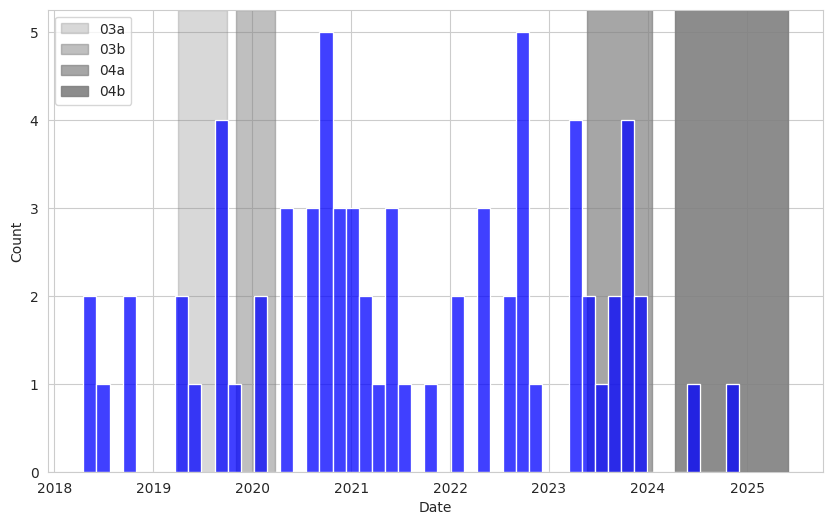

In [2]:
# Use mjd_0 value to plot the number of objects over time. Only plot the unique objects.
df_count = df_observed[df_observed.obj_id != 'AT2017gfo'].groupby('obj_id').mjd_0.min().reset_index()
df_count['mjd_0'] = Time(df_count['mjd_0'], format='mjd').to_value('iso')

plt.figure(figsize=(10,6))
plt.axvspan(pd.Timestamp('2019-04-01'), pd.Timestamp('2019-10-01'), color='gray', alpha=0.3, label='03a')
plt.axvspan(pd.Timestamp('2019-11-01'), pd.Timestamp('2020-03-27'), color='gray', alpha=0.5, label='03b')
plt.axvspan(pd.Timestamp('2023-05-23'), pd.Timestamp('2024-01-16'), color='gray', alpha=0.7, label='04a')
plt.axvspan(pd.Timestamp('2024-04-10'), pd.Timestamp('2025-06-01'), color='gray', alpha=0.90, label='04b')
sns.histplot(pd.to_datetime(df_count['mjd_0']), bins=50, color='blue')
plt.xlabel('Date')
plt.ylabel('Count')
#plt.title('Potential Kilonovae from ZTFReST')
plt.legend();
plt.savefig('figures/candidate_kne_hist.pdf') if savefigs else None

In [3]:
## average number of observations per object
print('average number of observations per object')
print(df_observed.groupby('obj_id').size().mean())

average number of observations per object
35.605633802816904


In [4]:
## breakdown of percent of observations per filter. found by counting the number of items with a non-nan value for each filter column
print('breakdown of percent of observations per filter')
for item in filters:
    print(item)
    print(df_observed[f'mag_{item}'].count()/len(df_observed))

breakdown of percent of observations per filter
ztfg
0.4675632911392405
ztfr
0.4560917721518987
ztfi
0.07634493670886076


In [5]:
df_observed[df_observed.t < 25].groupby('obj_id')['t'].diff().describe()

count    2457.000000
mean        0.457941
std         1.253434
min         0.000000
25%         0.000000
50%         0.005000
75%         0.093958
max        18.920289
Name: t, dtype: float64

In [6]:
df_observed.groupby('obj_id')['t'].describe()

,count,mean,std,min,25%,50%,75%,max
obj_id,,,,,,,,
AT2017gfo,35.0,2.702743,2.594591,0.0,0.869000,1.738000,3.243000,8.769000
ZTF18aakuewf,70.0,8.011597,5.808719,0.0,4.022263,7.061377,10.991270,21.959028
ZTF18aalrxas,57.0,12.638434,7.883201,0.0,4.023889,15.922639,19.932014,22.924445
ZTF18abffyqp,113.0,12.965703,7.358590,0.0,7.013056,14.078785,18.994039,24.096273
ZTF18abvkmgw,23.0,5.366637,3.146875,0.0,2.950839,4.994224,7.966314,11.903345
...,...,...,...,...,...,...,...,...
ZTF23abobwsd,37.0,6.849053,4.965758,0.0,2.983750,5.952870,10.013102,18.910961
ZTF23absbqun,18.0,3.327628,2.002244,0.0,1.989768,3.055336,4.901296,7.121586
ZTF23abtycgb,26.0,4.930443,7.173073,0.0,0.378472,2.010515,3.017326,22.014398


In [33]:
df_rates = pd.read_csv('gp_objects_rates.csv')
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
df_2019 = pd.read_csv('bulla_2019_rates.csv')
#df_rates.loc[df_rates['obj_id'] == 'ZTF24abvevzs', 'type'] = 'ZTF24abvevzs'

display(df_rates)
display(df_2019)



,obj_id,type,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,ztfg_peak_gr_color,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
0,AT2017gfo,Kilonova,0.009840,0.000000,-15.778388,0.000000,-15.832157,0.000000,-15.923154,0.053769,...,NaN,NaN,NaN,NaN,1.992556,1.468151,1.992556,0.936347,1.992556,0.657337
1,ZTF18aakuewf,Ibn,0.063600,3.898491,-19.662041,4.198375,-19.545710,NaN,NaN,-0.123851,...,4.198375,-0.263379,NaN,NaN,1.999226,0.049847,1.999226,0.091061,NaN,NaN
2,ZTF18aalrxas,IIb,0.058200,1.961364,-18.241097,2.059432,-17.955813,NaN,NaN,-0.285946,...,2.059432,-0.255473,NaN,NaN,1.961364,0.269659,1.961364,0.136353,NaN,NaN
3,ZTF18abffyqp,II,0.031000,0.950871,-17.541600,2.502293,-17.327431,NaN,NaN,-0.266512,...,2.502293,-0.051043,NaN,NaN,1.951789,0.057264,1.951789,0.041668,NaN,NaN
4,ZTF18abvkmgw,Ib,0.038470,4.277578,-17.382398,4.730358,-17.389784,NaN,NaN,-0.003031,...,4.730358,-0.339628,NaN,NaN,1.989848,0.074062,1.989848,0.042339,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,ZTF23abobwsd,IIb,0.024000,0.000000,-17.108568,0.000000,-17.180304,0.000000,-17.100538,0.071736,...,NaN,NaN,NaN,NaN,1.978073,0.112160,1.978073,0.061998,1.978073,0.019844
67,ZTF23absbqun,Ib,0.010100,1.853466,-14.354963,1.846337,-15.071233,NaN,NaN,0.716266,...,1.846337,-0.095967,NaN,NaN,1.996040,0.270486,1.996040,0.144054,NaN,NaN
68,ZTF23abtycgb,II,0.020127,0.000000,-15.654520,0.000000,-15.700839,NaN,NaN,0.046319,...,NaN,NaN,NaN,NaN,1.997370,0.610436,1.997370,0.424219,NaN,NaN
69,ZTF24aascytf,II,0.038000,0.931519,-17.437112,1.269422,-17.117116,1.589061,-16.796361,-0.367762,...,1.269422,-0.491867,1.589061,-0.453188,1.990893,0.622009,1.990893,0.441016,1.990893,0.286326


,ztfg_peak_mag,ztfg_peak_time,ztfg_rise_rate,ztfg_fade_rate,ztfg_fwhm,ztfg_rise_hwhm,ztfg_fade_hwhm,ztfr_peak_mag,ztfr_peak_time,ztfr_rise_rate,...,ztfi_rise_hwhm,ztfi_fade_hwhm,ztfg_peak_gr_color,ztfg_peak_gi_color,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color,model,obj_id
0,-14.803,0.5,NaN,1.182000,NaN,NaN,NaN,-15.659,0.5,NaN,...,NaN,NaN,0.856,0.903,0.856,0.047,0.903,0.047,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0
1,-14.730,0.5,NaN,1.165333,NaN,NaN,NaN,-15.582,0.5,NaN,...,NaN,NaN,0.852,0.903,0.852,0.051,0.903,0.051,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta25.84_d...
2,-14.655,0.5,NaN,1.149333,NaN,NaN,NaN,-15.505,0.5,NaN,...,NaN,NaN,0.850,0.910,0.850,0.060,0.910,0.060,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta36.87_d...
3,-14.578,0.5,NaN,1.130000,NaN,NaN,NaN,-15.429,0.5,NaN,...,NaN,NaN,0.851,0.913,0.851,0.062,0.913,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta45.57_d...
4,-14.501,0.5,NaN,1.108000,NaN,NaN,NaN,-15.355,0.5,NaN,...,NaN,NaN,0.854,0.916,0.854,0.062,0.916,0.062,bulla_2019,nph1.0e+06_mej0.01_phi15_T3.0e+03_theta53.13_d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-13.058,2.5,-0.7430,0.028000,4.5,1.0,3.5,-13.853,3.0,-0.7204,...,1.5,5.0,0.762,1.264,0.837,0.512,1.380,0.526,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta66.42_d...
2196,-13.039,2.5,-0.7495,0.016667,4.5,1.0,3.5,-13.845,3.0,-0.7248,...,1.5,5.0,0.771,1.273,0.831,0.515,1.389,0.537,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta72.54_d...
2197,-13.029,2.5,-0.7520,0.010667,4.5,1.0,3.5,-13.841,3.0,-0.7208,...,1.5,5.0,0.779,1.278,0.828,0.514,1.386,0.534,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta78.46_d...
2198,-13.029,2.5,-0.7565,0.014000,4.5,1.0,3.5,-13.841,3.0,-0.7120,...,1.5,5.0,0.776,1.277,0.833,0.513,1.384,0.530,bulla_2019,nph1.0e+06_mej0.10_phi75_T9.0e+03_theta84.26_d...


In [8]:
df_rates[df_rates['type']=='IIb'].ztfr_rise_rate.describe()

count    9.000000
mean    -0.262725
std      0.362849
min     -1.154254
25%     -0.255473
50%     -0.097498
75%     -0.071414
max     -0.036727
Name: ztfr_rise_rate, dtype: float64

In [9]:
types = df_rates['type'].unique()
## reorder dictionary so "kilonova" is last
types = [x for x in types if x != 'Kilonova'] + ["Kilonova"] if "Kilonova" in types else types
print(types[0])
print('number of types:', len(types))
colors = sns.color_palette("husl", len(types))
colors_dict = {types[i]: colors[i] for i in range(len(types))}
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+', 'x', '|', '_', '.']
type_style_dict = {types[i]: {'color': colors[i], 'marker': markers[i], "size":50, 'alpha':0.9, 'zorder':1} for i in range(len(types))}
if "Kilonova" in types:
    type_style_dict['Kilonova'] = {'color': 'lime', 'marker': '1', 'size': 300, 'alpha': 1, 'zorder': 100}

Ibn
number of types: 19


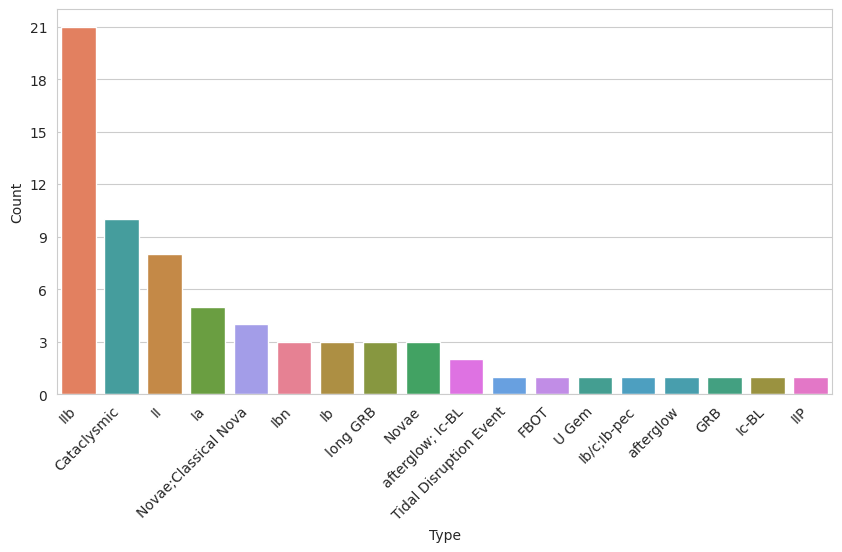

In [10]:
from matplotlib.ticker import MaxNLocator
type_counts = df_rates[df_rates.type != 'Kilonova']['type'].value_counts()
sorted_types = type_counts.index
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.set_style('whitegrid')
sns.countplot(data=df_rates[df_rates.type != 'Kilonova'], x='type', order=sorted_types, palette=colors_dict, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# sns.set(style='whitegrid')
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax.grid(axis='y')
ax.set_ylim(0,22)
plt.savefig('figures/type_distribution.pdf', bbox_inches='tight') if savefigs else None
plt.show()

Color at Peak

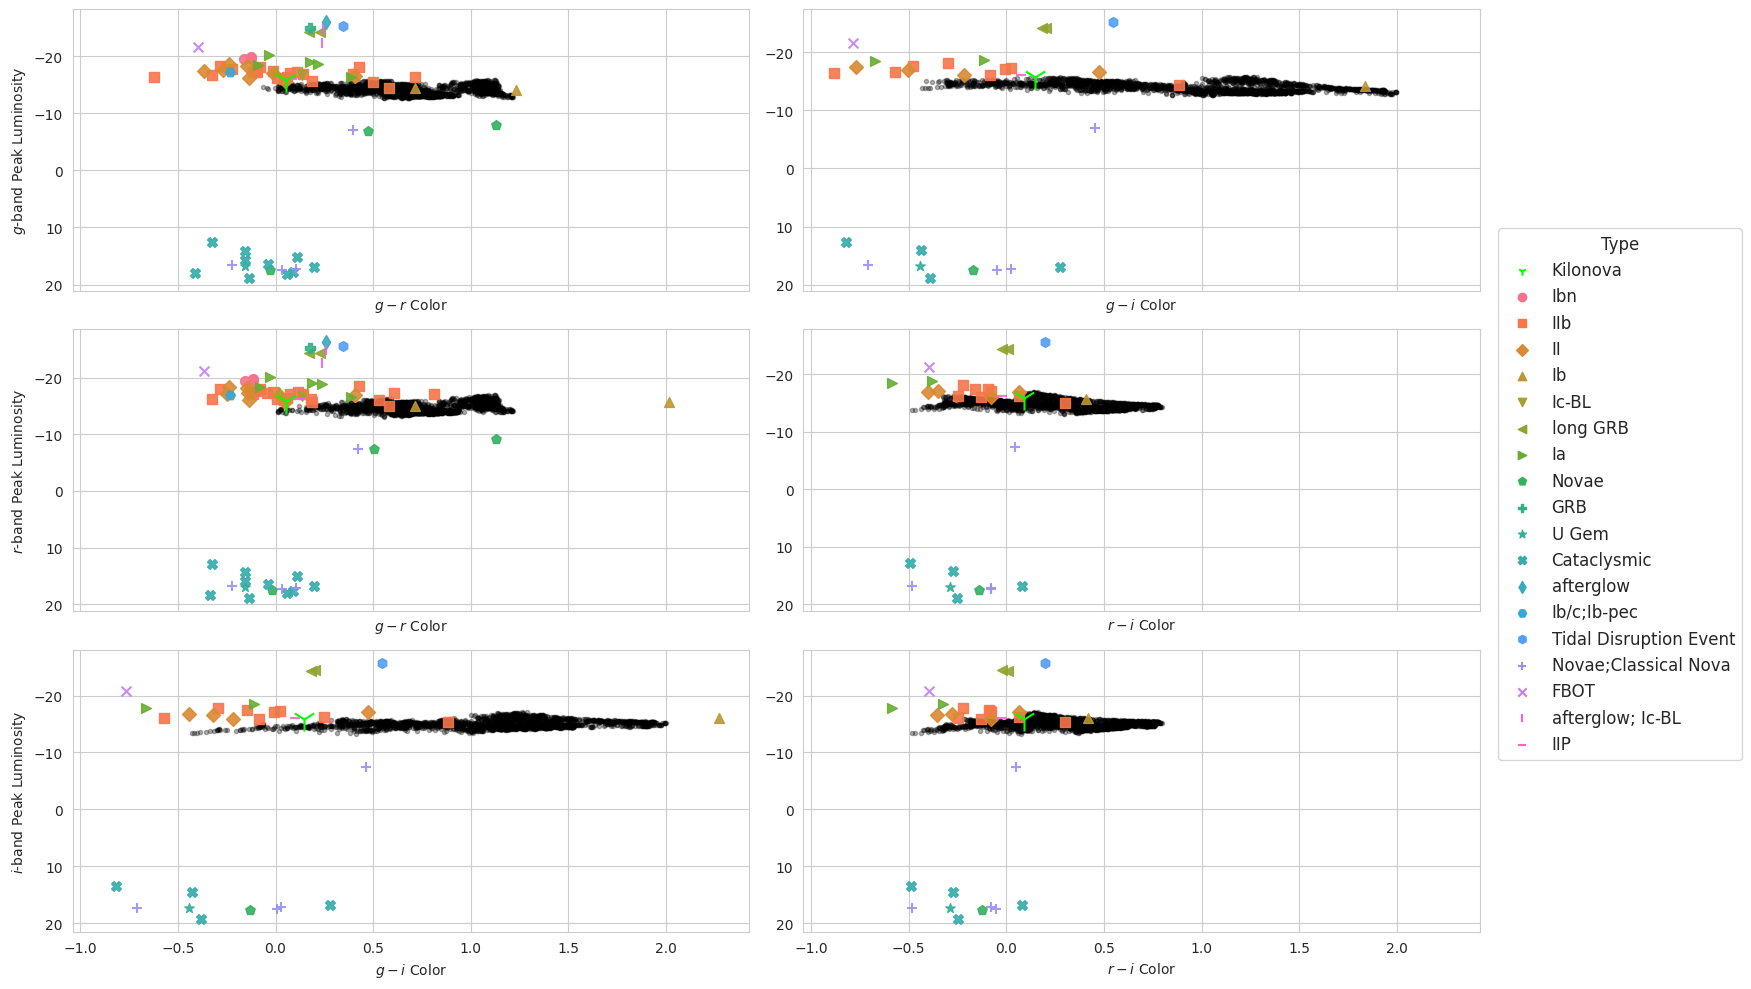

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

axs = axs.flatten()

peaks = ['ztfg_peak_gr_color', 'ztfg_peak_gi_color',
         'ztfr_peak_gr_color', 'ztfr_peak_ri_color',
         'ztfi_peak_gi_color', 'ztfi_peak_ri_color']

for ax, peak in zip(axs, peaks):
    ax.invert_yaxis()
    filter = peak.split('_')[0]
    color = peak.split('_')[-2]
    ax.scatter(df_2019[peak], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax.scatter(df_class[peak], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

## add legend to the right of the plots using the type_style_dict colors and markers (base on all of  the subplots)
handles, labels = [], []
for ax in axs:
    for type_ in df_rates['type'].unique():
        handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker']))
        labels.append(type_)
handles = handles[:len(df_rates['type'].unique())]
labels = labels[:len(df_rates['type'].unique())]
fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.17, 0.5),)
            
axs[0].set_ylabel("$\it{g}$-band Peak Luminosity"), axs[2].set_ylabel("$\it{r}$-band Peak Luminosity"), axs[4].set_ylabel("$\it{i}$-band Peak Luminosity");

axs[0].set_xlabel("$\it{g-r}$ Color"), axs[1].set_xlabel("$\it{g-i}$ Color");
axs[2].set_xlabel("$\it{g-r}$ Color"), axs[3].set_xlabel("$\it{r-i}$ Color");
axs[4].set_xlabel("$\it{g-i}$ Color"), axs[5].set_xlabel("$\it{r-i}$ Color");
ax.figure.tight_layout()
plt.savefig('figures/peak_color_vs_peak_mag.pdf', bbox_inches='tight') if savefigs else None
plt.show();

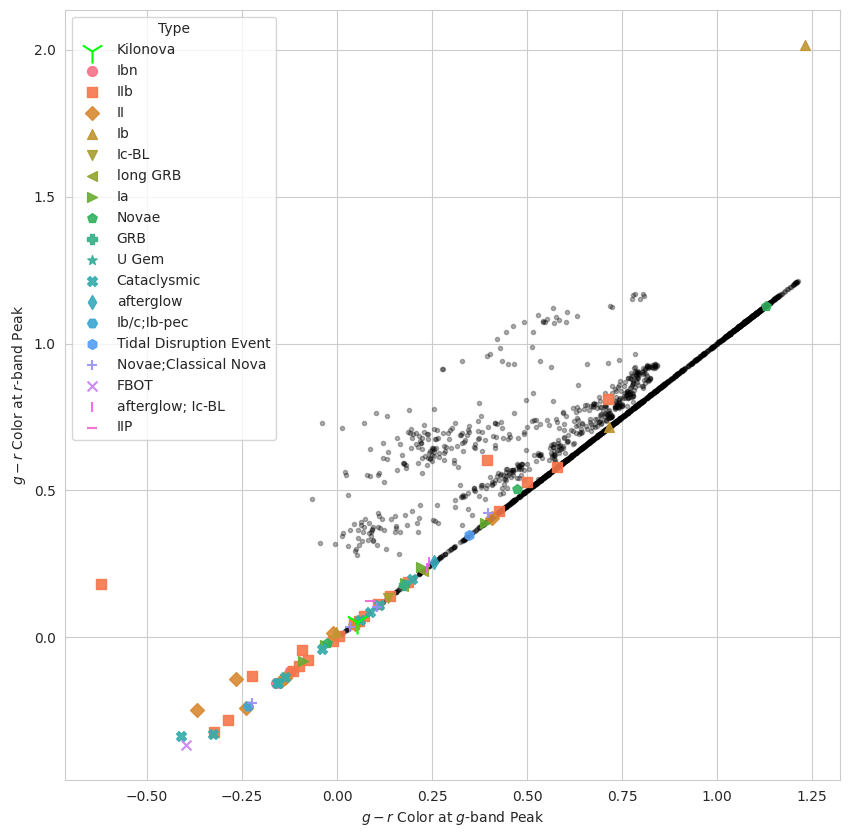

In [12]:
## compare the gr color at the peak of ztfg and the peak of ztfr
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.invert_yaxis()
ax.scatter(df_2019['ztfg_peak_gr_color'], df_2019['ztfr_peak_gr_color'], alpha=0.3, color='k',marker='.')

for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_peak_gr_color'].notnull()) & (df_rates['ztfr_peak_gr_color'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class['ztfg_peak_gr_color'], df_class['ztfr_peak_gr_color'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
ax.legend(title='Type')
ax.set_xlabel("$\it{g-r}$ Color at $\it{g}$-band Peak")
ax.set_ylabel("$\it{g-r}$ Color at $\it{r}$-band Peak")
plt.savefig('figures/gr_color_at_g_vs_r_peak.pdf', bbox_inches='tight') if savefigs else None
plt.show();

FWHM vs Peak Magnitude

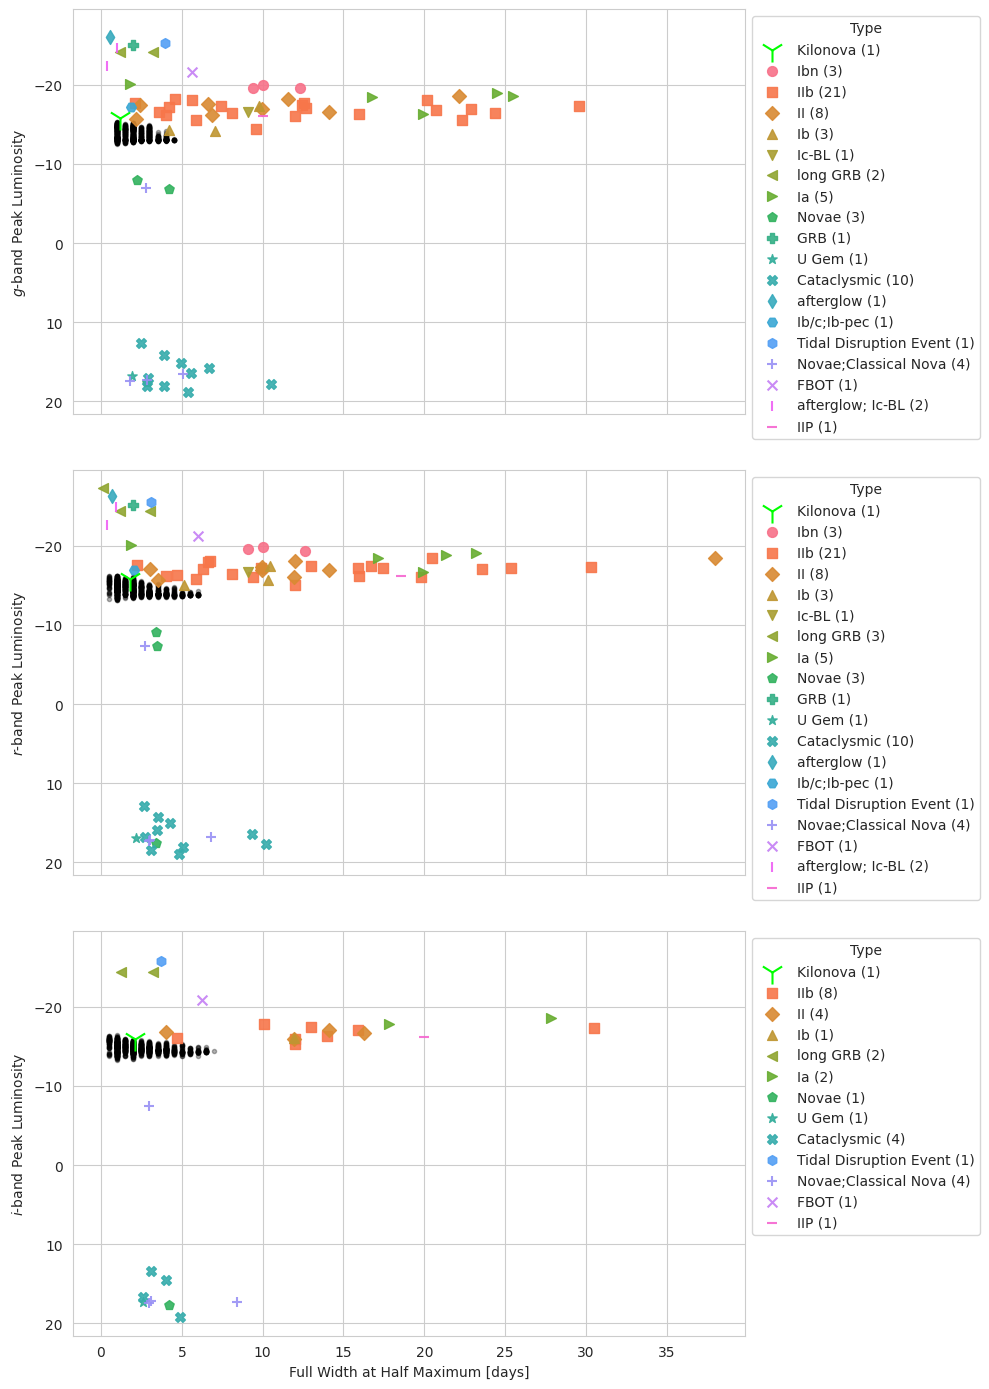

In [13]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 14), 
                       sharex=True,sharey=True, tight_layout=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fwhm'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fwhm'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_fwhm'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates[df_rates['ztfg_fwhm'].notnull() & df_rates['ztfg_peak_mag'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fwhm'].notnull() & df_rates['ztfr_peak_mag'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fwhm'].notnull() & df_rates['ztfi_peak_mag'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Full Width at Half Maximum [days]");
#ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
#ax[0].set_xlim(None,-2.0)
plt.savefig('figures/fwhm_vs_peak_luminosity.pdf', bbox_inches='tight') if savefigs else None

plt.show()

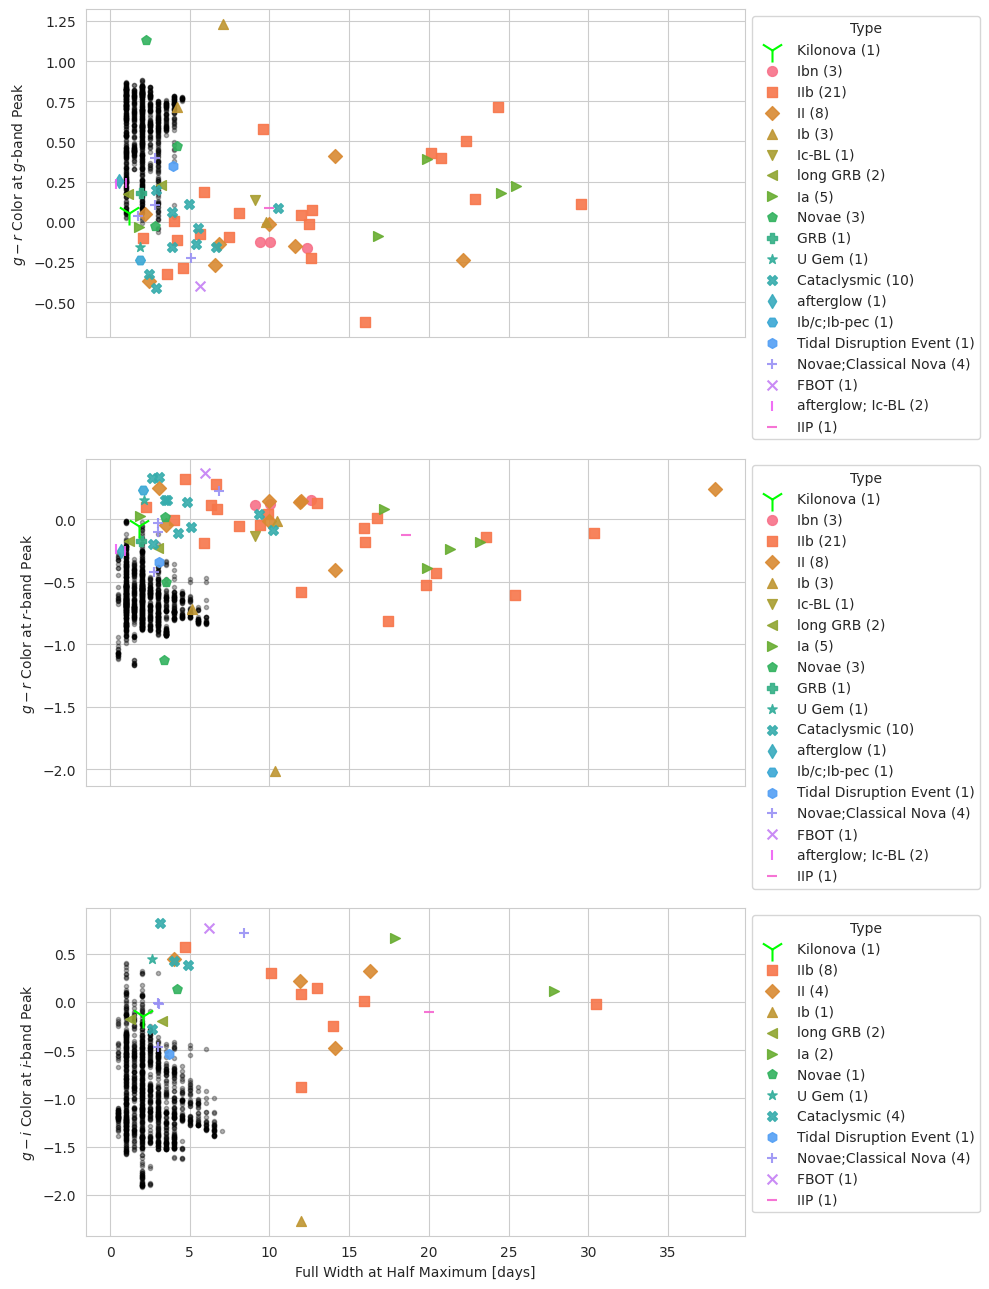

In [14]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 13), tight_layout=True,
                       sharex=True)#,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()


x_array = ['ztfg_fwhm', 'ztfr_fwhm', 'ztfi_fwhm']
y_array = ['ztfg_peak_gr_color', 'ztfr_peak_gr_color', 'ztfi_peak_gi_color']
for axi, (x, y) in enumerate(zip(x_array, y_array)):
    if y == 'ztfg_peak_gr_color': ## makes it so all colors are difference between g and other band
        color_factor = 1
    else:
        color_factor = -1
    
    ax[axi].scatter(df_2019[x], color_factor*df_2019[y], alpha=0.3,color='k',marker='.')
    df_class = df_rates[(df_rates[x].notnull()) & (df_rates[y].notnull())]

    for type_ in df_rates['type'].unique():
        df_class_type = df_class[df_class['type'] == type_]
        if len(df_class_type) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class_type[x], color_factor * df_class_type[y],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates[(df_rates['ztfg_fwhm'].notnull()) & (df_rates['ztfg_peak_gr_color'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fwhm'].notnull() & df_rates['ztfr_peak_gr_color'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fwhm'].notnull() & df_rates['ztfi_peak_gi_color'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
# ax[0].set_ylabel("$\it{g-r}$ Color at $\it{g}$-band Peak"), ax[1].set_ylabel("$\it{r-g}$ Color at $\it{r}$-band Peak"), ax[2].set_ylabel("$\it{i-g}$ Color at $\it{i}$-band Peak") ## without color factor labels
ax[0].set_ylabel("$\it{g-r}$ Color at $\it{g}$-band Peak"), ax[1].set_ylabel("$\it{g-r}$ Color at $\it{r}$-band Peak"), ax[2].set_ylabel("$\it{g-i}$ Color at $\it{i}$-band Peak")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Full Width at Half Maximum [days]");


plt.savefig('figures/fwhm_vs_peak_color.pdf', bbox_inches='tight') if savefigs else None
plt.show()

/tmp/ipykernel_323012/336326877.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in lgnd.legendHandles:


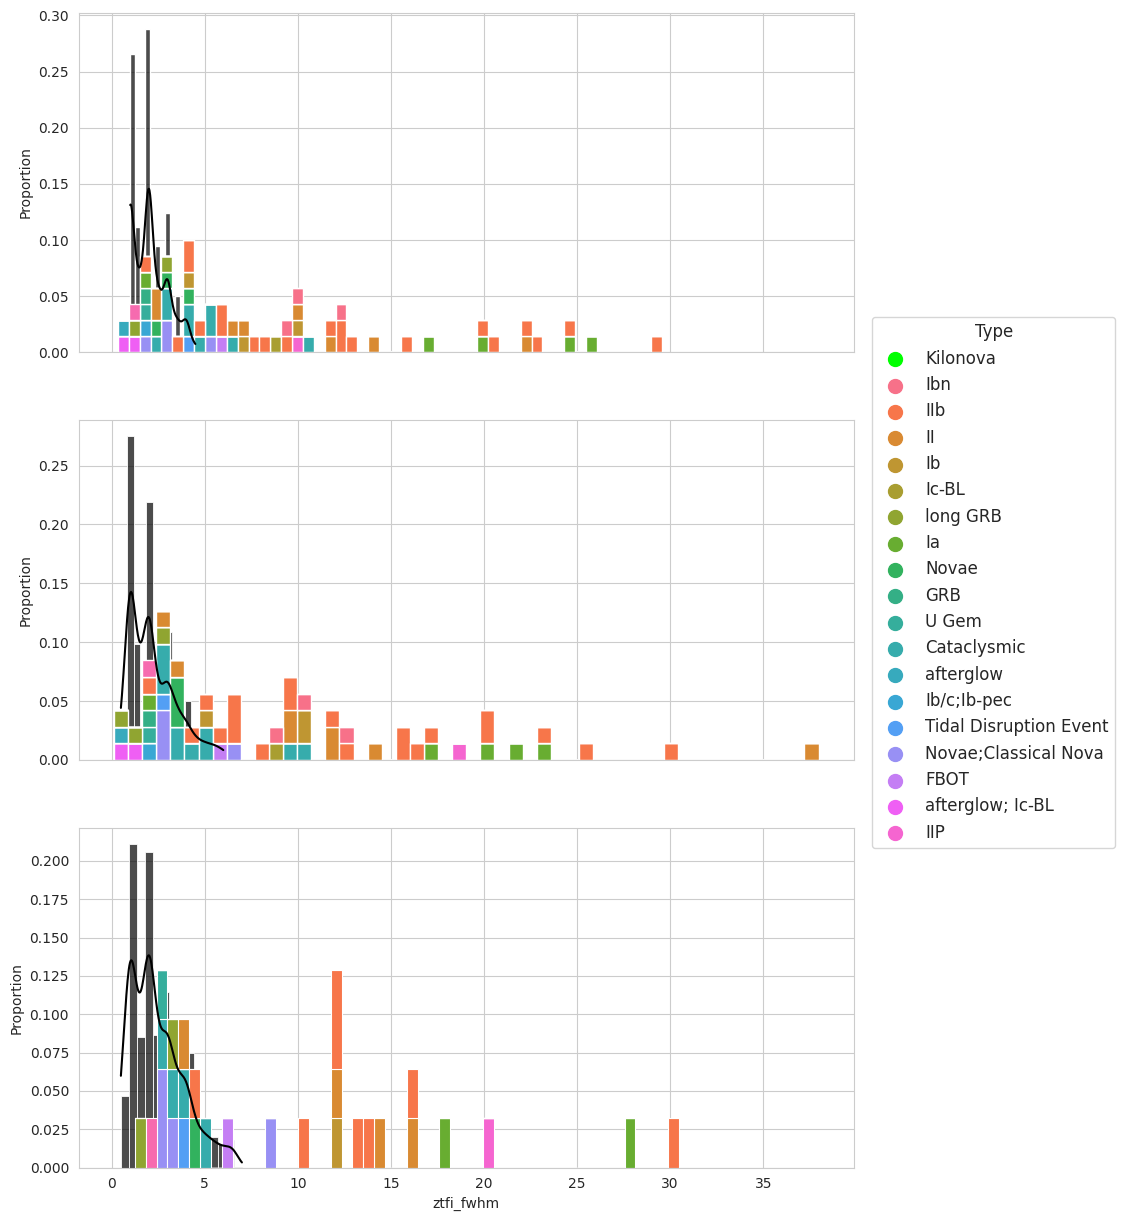

In [15]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    # ax[axi].hist(df_2019[f'{filter}_fwhm'], color='k',bins=50, density=True)
    # sns.histplot(df_2019.sample(n=69,random_state=1), x=f'{filter}_fwhm', color='k',  ax=ax[axi], alpha=0.7, stat='count',kde=True)
    # sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, bins=50, ax=ax[axi], alpha=1, stat='count', multiple='stack', legend=False)
    
    sns.histplot(df_2019, x=f'{filter}_fwhm', color='k',  ax=ax[axi], alpha=0.7, stat='proportion',kde=True)
    sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, bins=50, ax=ax[axi], alpha=1, stat='proportion', multiple='stack', legend=False)
    
    
handles, labels = [], []
for ax in axs:
    for type_ in df_rates['type'].unique():
        handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker='o'))
        labels.append(type_)
handles = handles[:len(df_rates['type'].unique())]
labels = labels[:len(df_rates['type'].unique())]
lgnd = fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.17, 0.5),);
for item in lgnd.legendHandles:
    item._sizes = [100]


/tmp/ipykernel_323012/2020651778.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in lgnd.legendHandles:


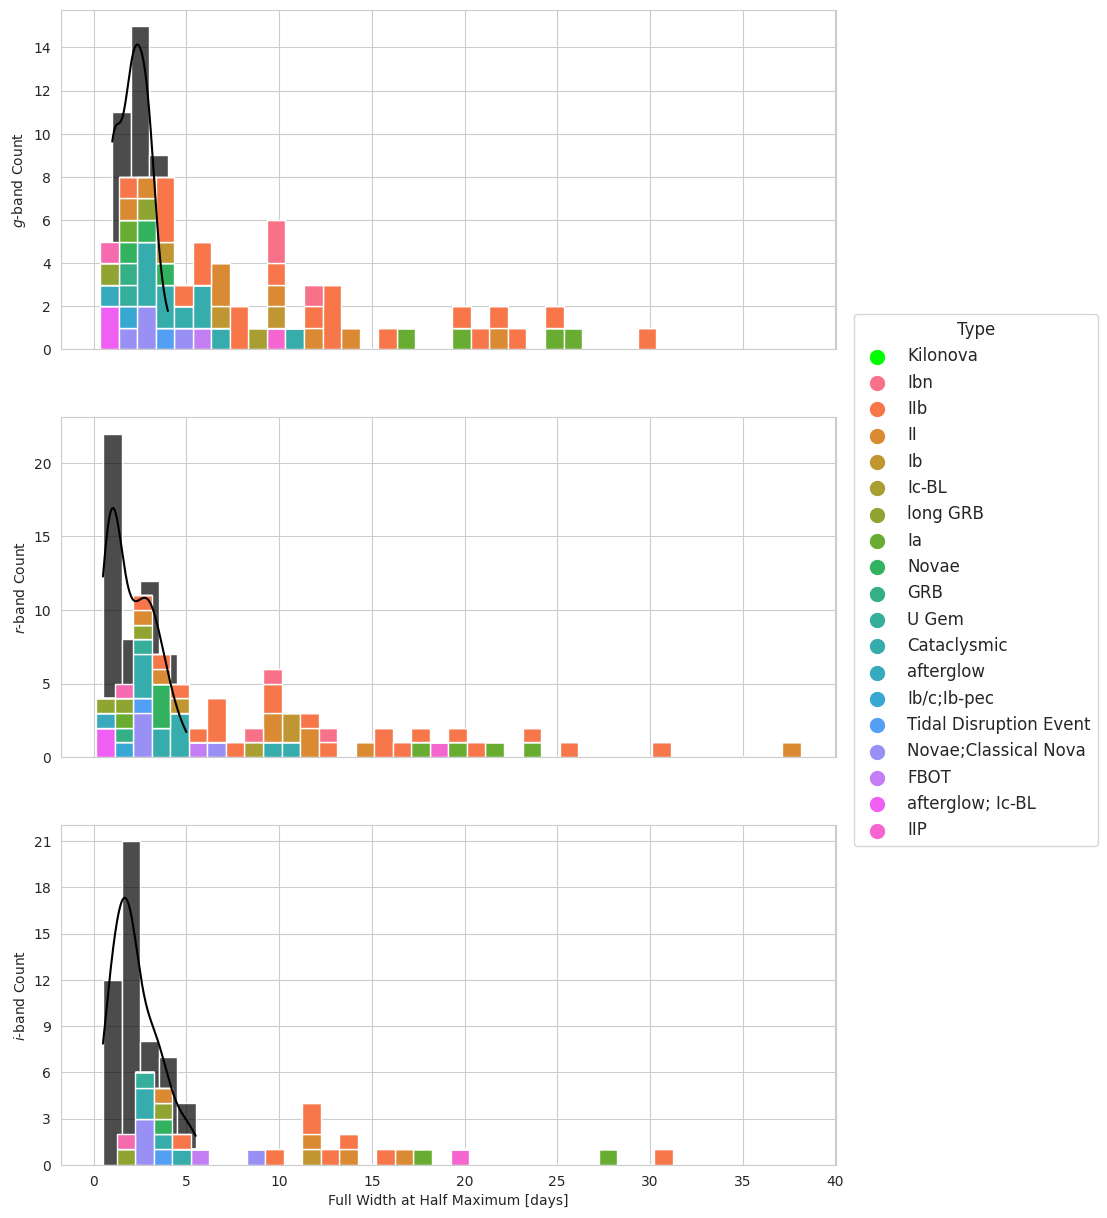

In [16]:
from matplotlib.ticker import MaxNLocator
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True,)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
ax[0].set_ylabel("$\it{g}$-band Count"), ax[1].set_ylabel("$\it{r}$-band Count"), ax[2].set_ylabel("$\it{i}$-band Count")  
ax[2].set_xlabel("Full Width at Half Maximum [days]");
for axi, filter in enumerate(filters):
    # ax[axi].hist(df_2019[f'{filter}_fwhm'], color='k',bins=50, density=True)
    sns.histplot(df_2019.sample(n=69,random_state=1), x=f'{filter}_fwhm', color='k',  binwidth=1, ax=ax[axi], alpha=0.7, stat='count',kde=True)
    sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, binwidth=1, ax=ax[axi], alpha=1, stat='count', multiple='stack', legend=False)
    
    # sns.histplot(df_2019, x=f'{filter}_fwhm', color='k',  ax=ax[axi], alpha=0.7, stat='proportion',kde=True)
    # sns.histplot(data=df_rates, x=f'{filter}_fwhm', hue='type', palette=colors_dict, bins=50, ax=ax[axi], alpha=1, stat='proportion', multiple='stack', legend=False)
ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))   
  
handles, labels = [], []
for ax in axs:
    for type_ in df_rates['type'].unique():
        handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker='o'))
        labels.append(type_)
handles = handles[:len(df_rates['type'].unique())]
labels = labels[:len(df_rates['type'].unique())]
lgnd = fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.17, 0.5),);
for item in lgnd.legendHandles:
    item._sizes = [100]



plt.savefig('figures/fwhm_hist_count.pdf', bbox_inches='tight') if savefigs else None

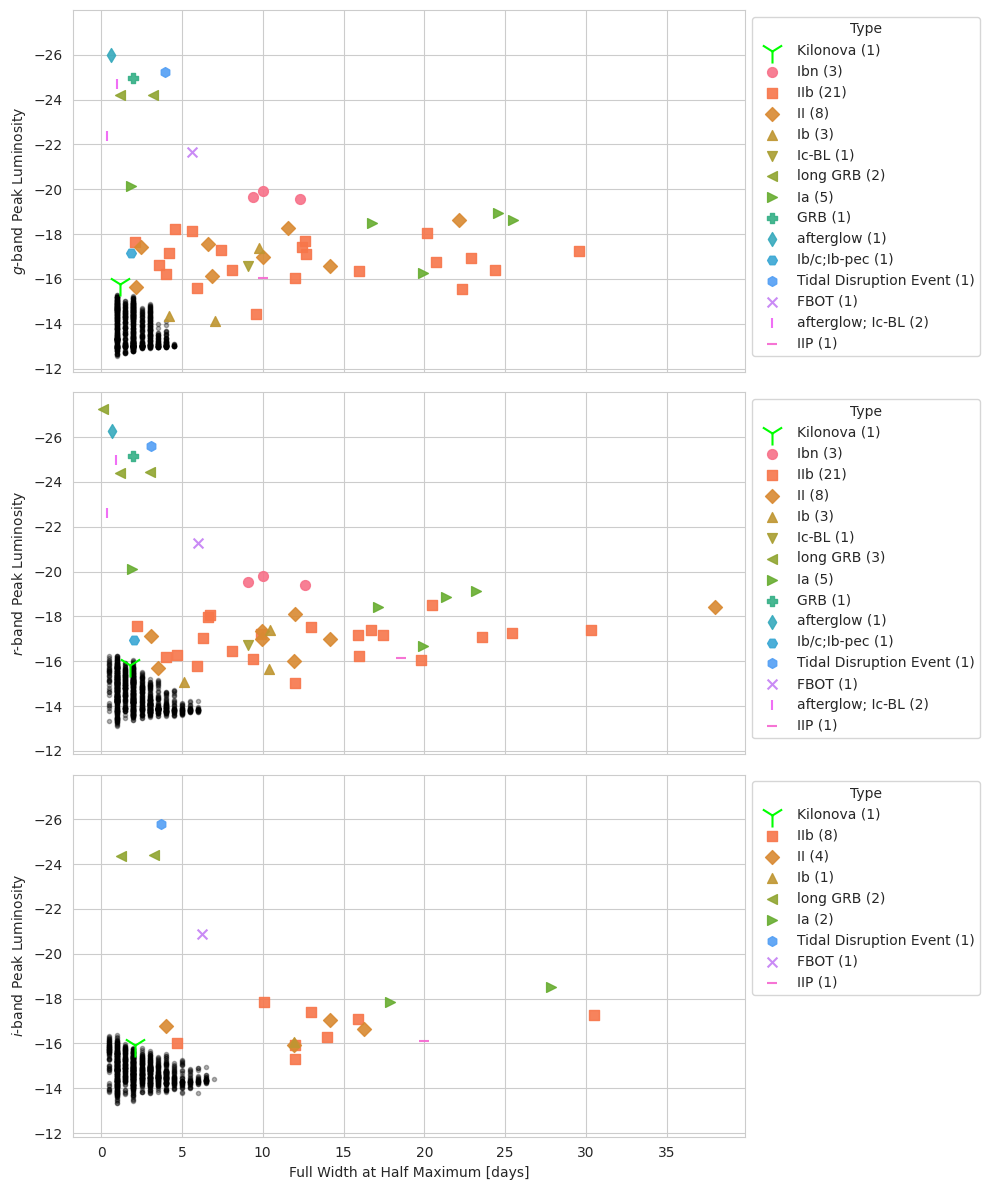

In [17]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 12), tight_layout=True,
                       sharex=True , sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fwhm'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull()) & (df_rates_far[f'{filter}_fwhm'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_fwhm'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_fwhm', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_fwhm', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();

class_counts_ztfg = df_rates_far[df_rates_far['ztfg_fwhm'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_fwhm'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_fwhm'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Full Width at Half Maximum [days]");
#ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
#ax[0].set_xlim(None,-2.0)

plt.savefig('figures/fwhm_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight') if savefigs else None
plt.show()

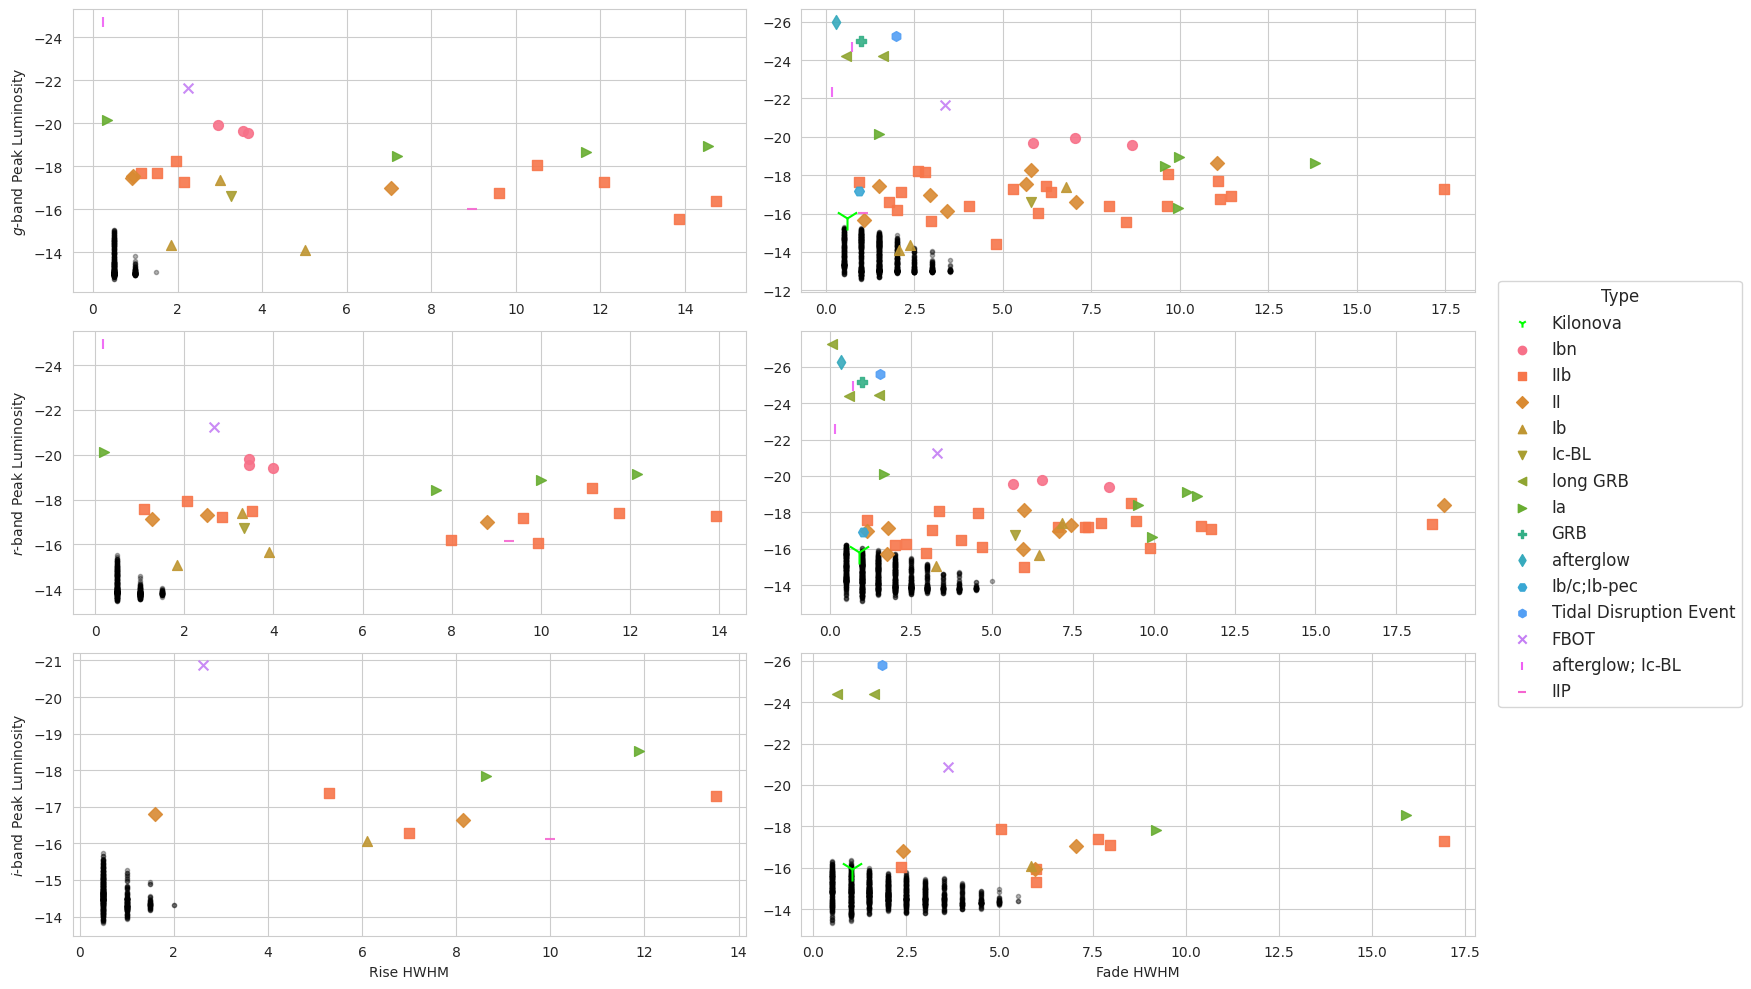

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10), tight_layout=True)

axs = axs.flatten()

peaks = ['ztfg_rise_hwhm', 'ztfg_fade_hwhm',
         'ztfr_rise_hwhm', 'ztfr_fade_hwhm',
         'ztfi_rise_hwhm', 'ztfi_fade_hwhm',]

for ax, peak in zip(axs, peaks):
    ax.invert_yaxis()
    # ax.grid()
    filter = peak.split('_')[0]
    color = peak.split('_')[-2]
    ax.scatter(df_2019[peak], df_2019[f'{filter}_peak_mag'], alpha=0.3, color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull()) & (df_rates_far[peak].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax.scatter(df_class[peak], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

## add legend to the right of the plots using the type_style_dict colors and markers (base on all of  the subplots)
handles, labels = [], []
for ax in axs:
    for type_ in df_rates_far['type'].unique():
        handles.append(ax.scatter([], [], color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker']))
        labels.append(type_)
handles = handles[:len(df_rates_far['type'].unique())]
labels = labels[:len(df_rates_far['type'].unique())]
fig.legend(handles, labels, loc='center right', title='Type', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.17, 0.5),)
            
axs[0].set_ylabel("$\it{g}$-band Peak Luminosity"), axs[2].set_ylabel("$\it{r}$-band Peak Luminosity"), axs[4].set_ylabel("$\it{i}$-band Peak Luminosity");

# axs[0].set_xlabel("$\it{g-r}$ Color"), axs[1].set_xlabel("$\it{g-i}$ Color");
# axs[2].set_xlabel("$\it{r-g}$ Color"), axs[3].set_xlabel("$\it{r-i}$ Color");
axs[4].set_xlabel("Rise HWHM"), axs[5].set_xlabel("Fade HWHM");

plt.savefig('figures/hwhm_vs_peak_mag_low_z_cutoff.pdf', bbox_inches='tight') if savefigs else None
plt.show();

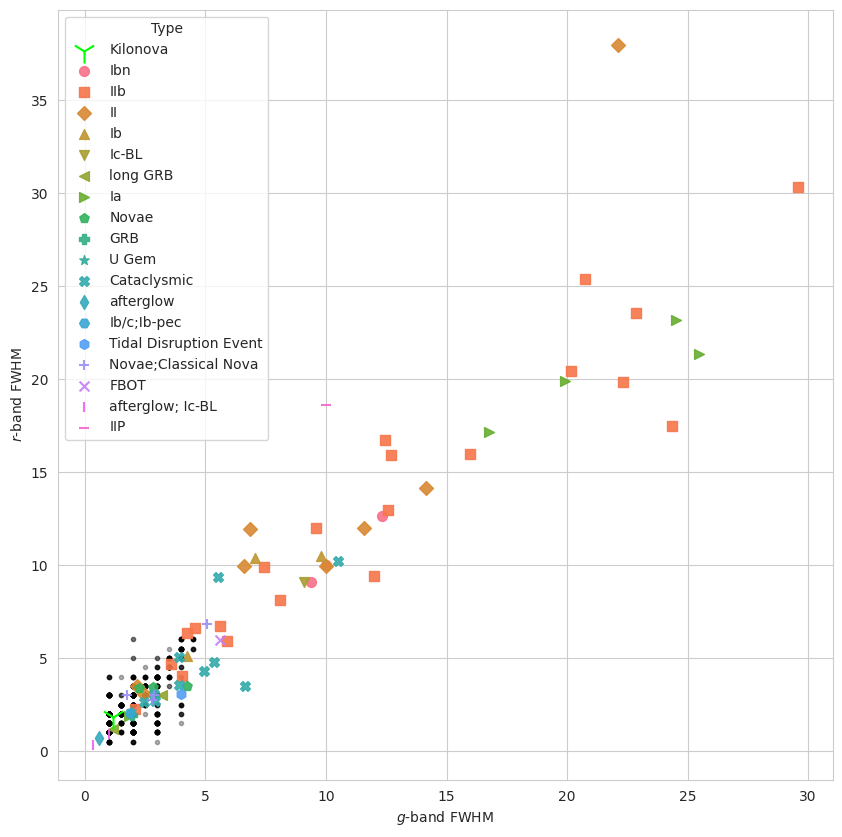

In [19]:
## compare the gr color at the peak of ztfg and the peak of ztfr
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.invert_yaxis()
# ax.grid()
ax.scatter(df_2019['ztfg_fwhm'], df_2019['ztfr_fwhm'], alpha=0.3, color='k',marker='.')

for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fwhm'].notnull()) & (df_rates['ztfr_fwhm'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class['ztfg_fwhm'], df_class['ztfr_fwhm'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
ax.legend(title='Type')
ax.set_xlabel("$\it{g}$-band FWHM");
ax.set_ylabel("$\it{r}$-band FWHM");
# plt.savefig('figures/ztfg_fwhm_vs_ztfr_fwhm.pdf', bbox_inches='tight')
plt.show();

Rise vs Peak Magnitude

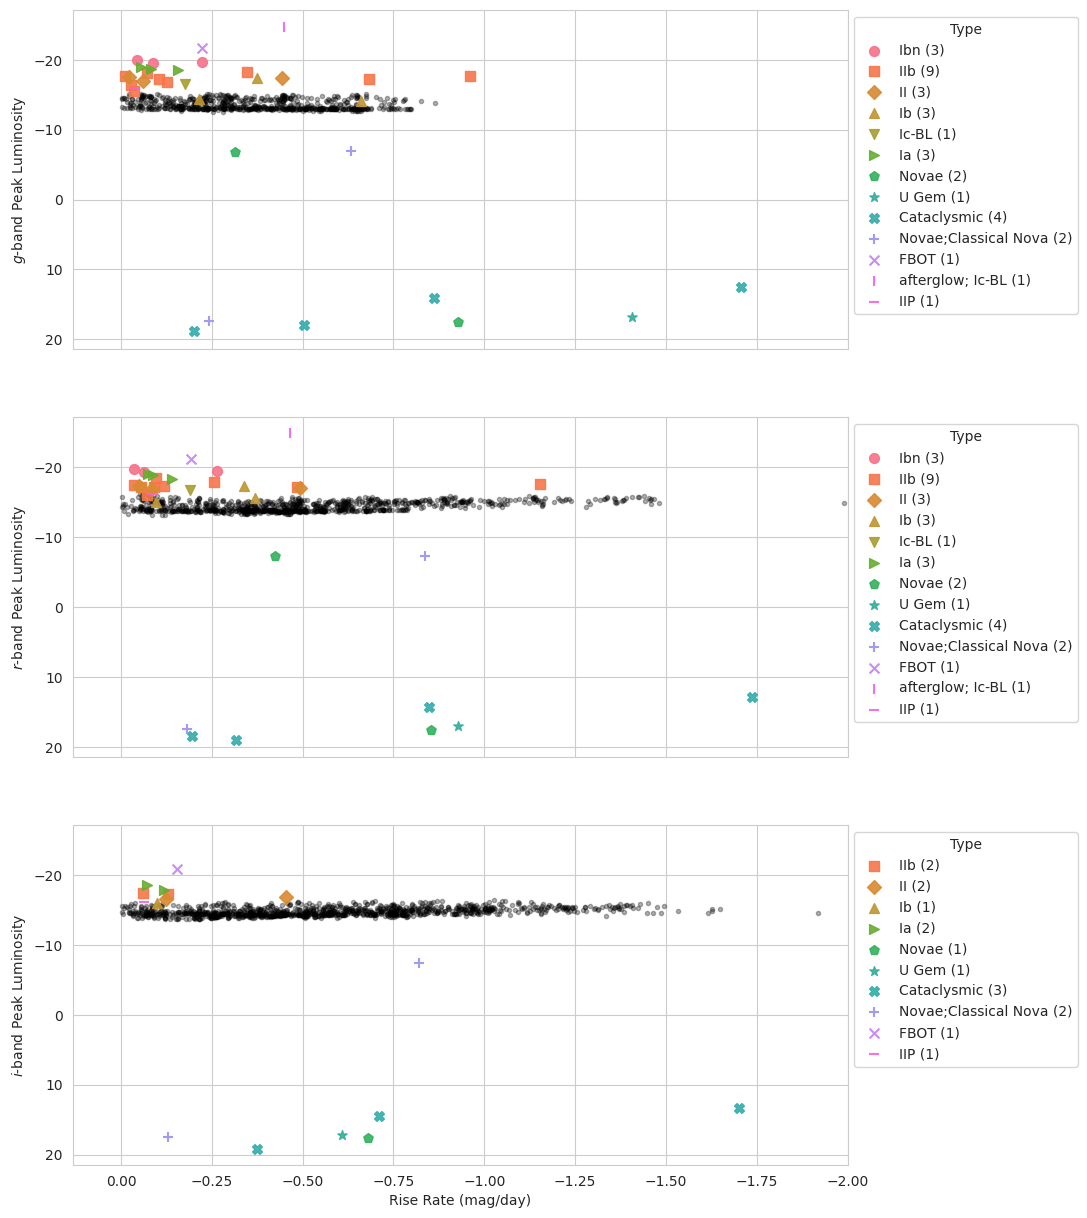

In [20]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True,sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
plt.savefig('figures/rise_rate_vs_peak_luminosity.pdf', bbox_inches='tight') if savefigs else None
plt.show()

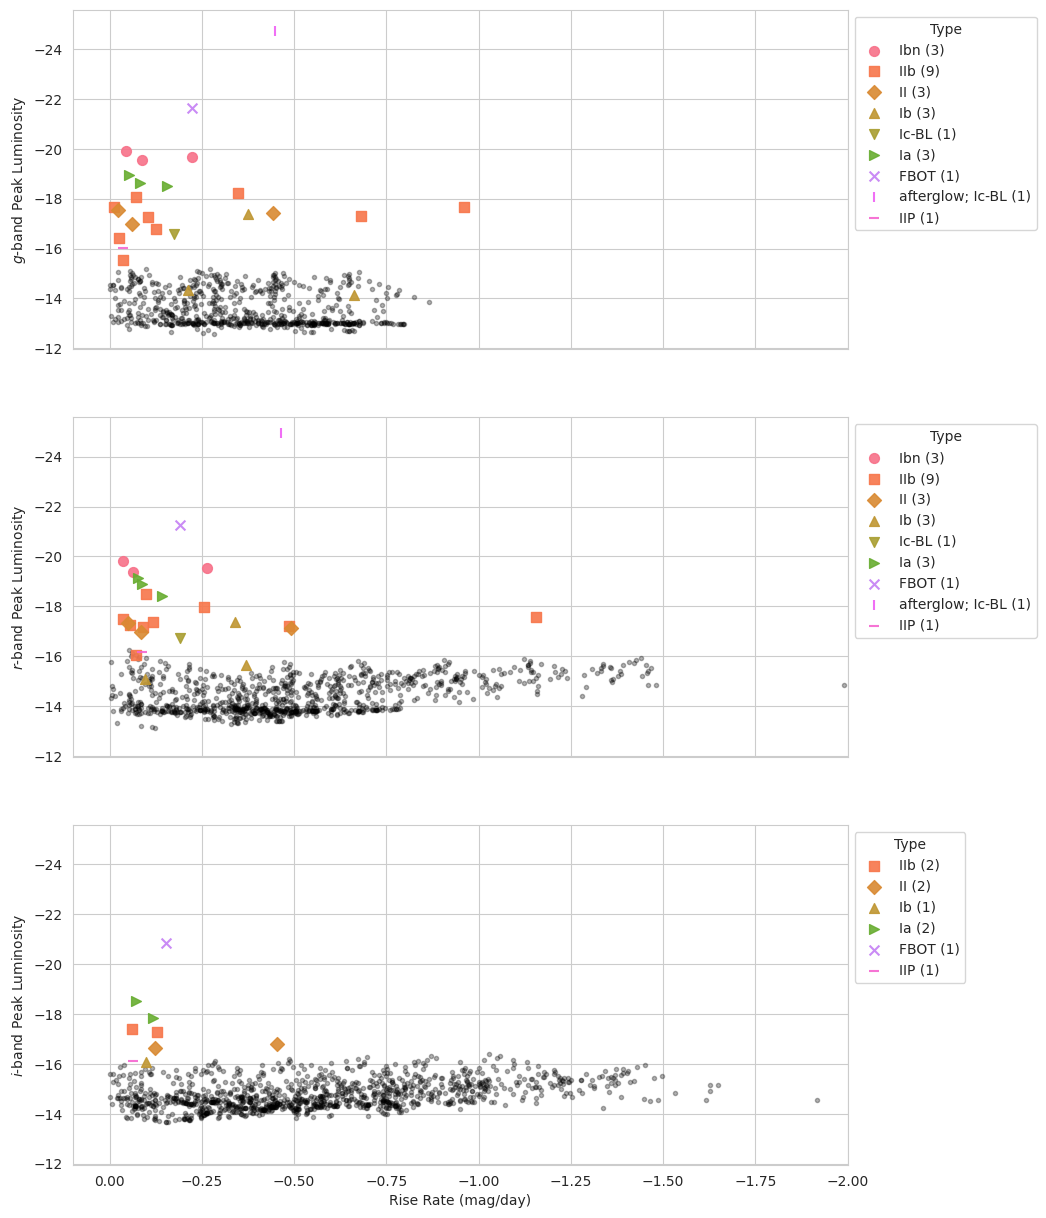

In [21]:
## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull()) & (df_rates_far[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates_far[df_rates_far['ztfg_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_rise_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_rise_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
# plt.legend(title='Type')  
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
ax[0].set_xlim(None,-2.0)
plt.savefig('figures/rise_rate_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight') if savefigs else None
plt.show()

Fade vs Peak Magnitude

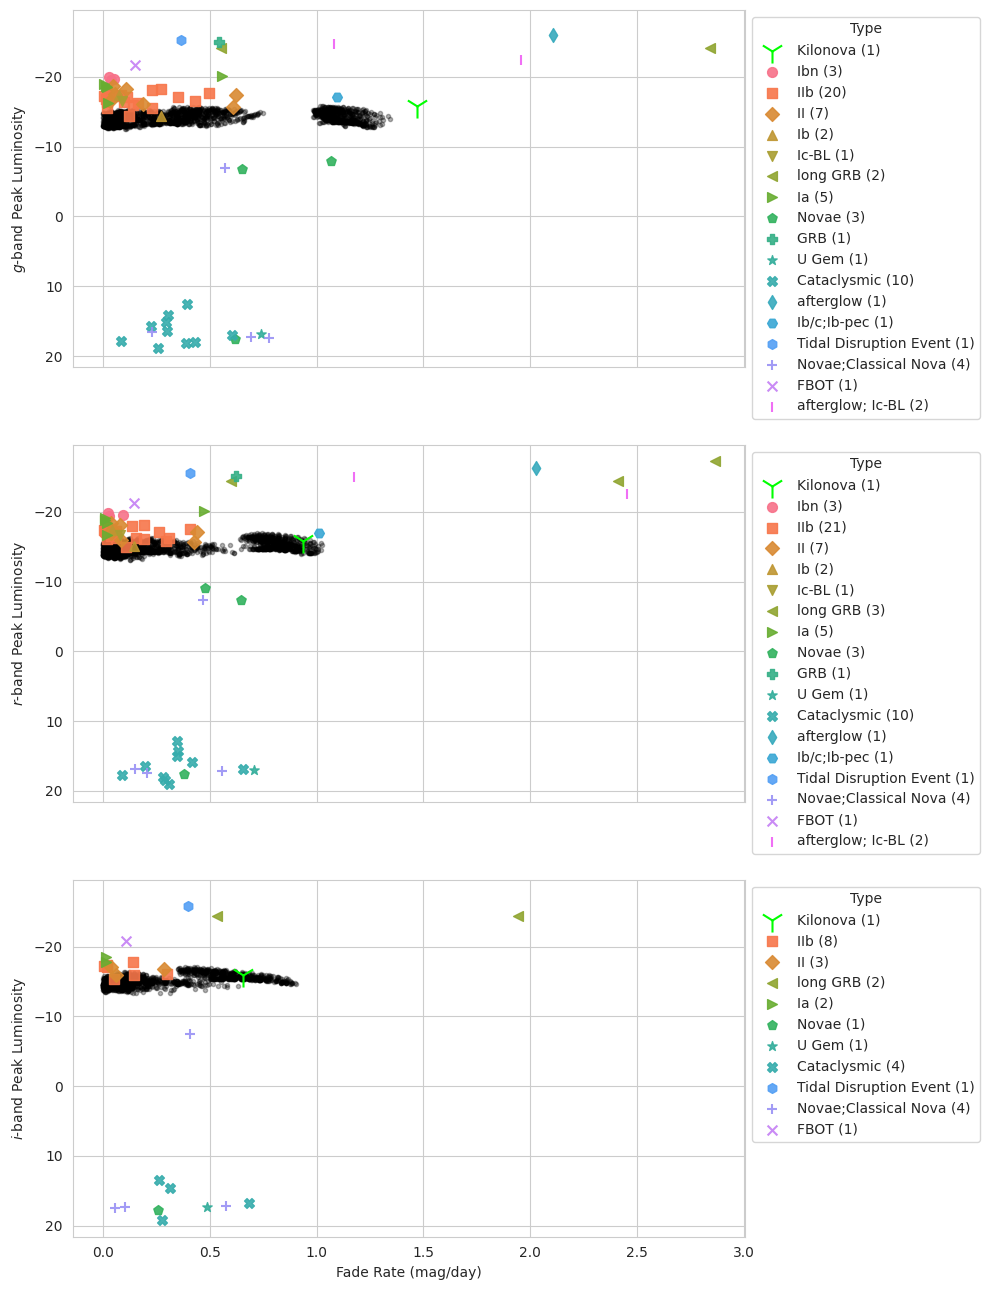

In [22]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates
fig, ax = plt.subplots(3, 1, figsize=(10, 13), 
                       sharex=True, sharey=True, tight_layout=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates['type'].unique():
        df_class = df_rates[(df_rates['type'] == type_) & (df_rates[f'{filter}_peak_mag'].notnull()) & (df_rates[f'{filter}_fade_rate'] > 0)]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[df_rates['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[df_rates['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[df_rates['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
plt.savefig('figures/fade_rate_vs_peak_luminosity.pdf', bbox_inches='tight') if savefigs else None
plt.show()

z > 0.001 objects

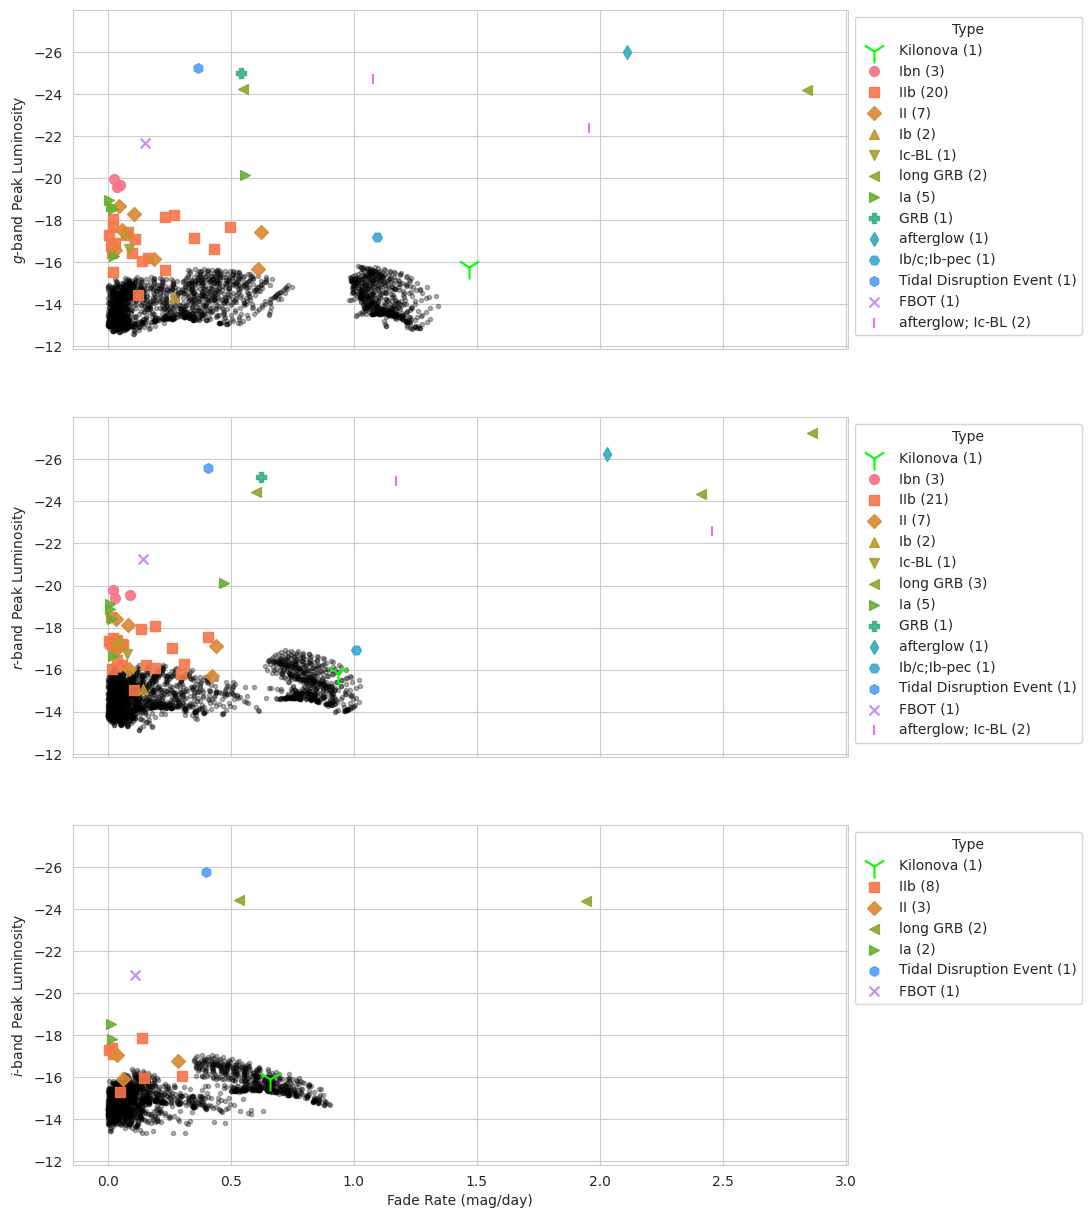

In [ ]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']

## plot the rate of fade vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_fade_rate'], df_2019[f'{filter}_peak_mag'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_peak_mag'].notnull()) & (df_rates_far[f'{filter}_fade_rate'] > 0)]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_fade_rate'], df_class[f'{filter}_peak_mag'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_fade_rate', y=f'{filter}_peak_mag', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_fade_rate', y=f'{filter}_peak_mag', hue='type', style='type', s=150, ax=ax[axi])

ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates_far[df_rates_far['ztfg_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates_far[df_rates_far['ztfr_fade_rate'].notnull()]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates_far[df_rates_far['ztfi_fade_rate'].notnull()]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("$\it{g}$-band Peak Luminosity"), ax[1].set_ylabel("$\it{r}$-band Peak Luminosity"), ax[2].set_ylabel("$\it{i}$-band Peak Luminosity")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Fade Rate (mag/day)");
plt.savefig('figures/fade_rate_vs_peak_luminosity_low_z_cutoff.pdf', bbox_inches='tight') if savefigs else None
plt.show()

Rise vs Fade

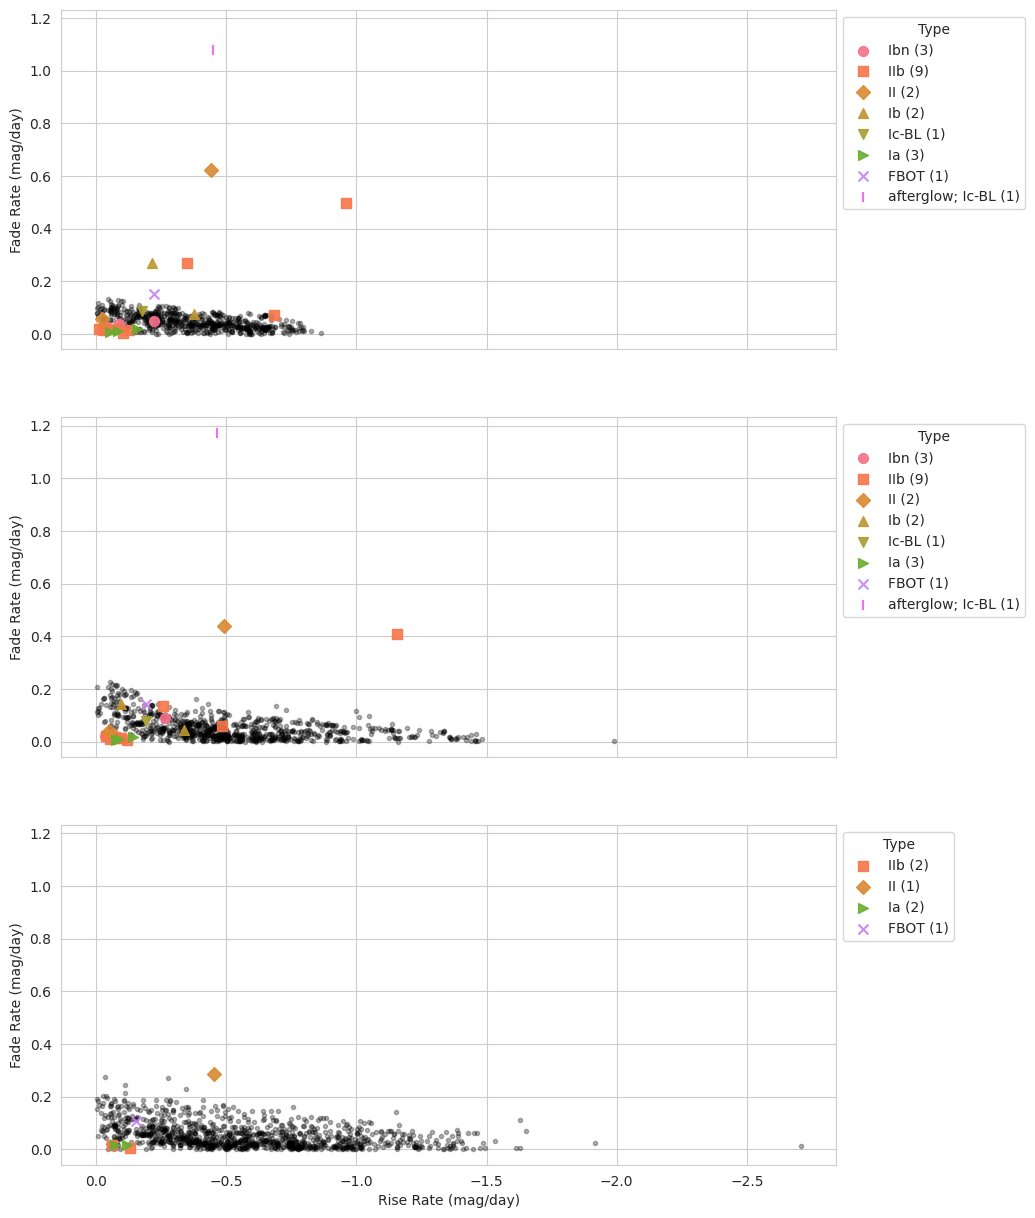

In [24]:

## maybe try this https://stackoverflow.com/questions/44731152/matplotlib-create-broken-axis-in-subplot
filters = ['ztfg', 'ztfr', 'ztfi']
df_rates_far = df_rates[df_rates['redshift'] > 0.001]
## plot the rate of rise vs the peak magnitude for each object in each filter using df_rates_far
fig, ax = plt.subplots(3, 1, figsize=(10, 15), 
                       sharex=True , sharey=True)
# ax[0].grid(), ax[1].grid(), ax[2].grid()
for axi, filter in enumerate(filters):
    ax[axi].scatter(df_2019[f'{filter}_rise_rate'], df_2019[f'{filter}_fade_rate'], alpha=0.3,color='k',marker='.')
    for type_ in df_rates_far['type'].unique():
        df_class = df_rates_far[(df_rates_far['type'] == type_) & (df_rates_far[f'{filter}_fade_rate'].notnull()) & (df_rates_far[f'{filter}_rise_rate'].notnull())]
        if len(df_class) > 0:
            s_ = type_style_dict[type_]['size']
            a_ = type_style_dict[type_]['alpha']
            c_ = type_style_dict[type_]['color']
            m_ = type_style_dict[type_]['marker']
            z_ = type_style_dict[type_]['zorder']
            ax[axi].scatter(df_class[f'{filter}_rise_rate'], df_class[f'{filter}_fade_rate'],
                            color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)
    
    #sns.scatterplot(data=df_2019, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', ax=ax[axi],alpha=0.5)
    #sns.scatterplot(data=df_rates_far, x=f'{filter}_rise_rate', y=f'{filter}_fade_rate', hue='type', style='type', s=150, ax=ax[axi])

#ax[0].invert_yaxis(), ax[1].invert_yaxis(), ax[2].invert_yaxis();
#ax[0].set_xlim(None,0.1), ax[1].set_xlim(None,0.1), ax[2].set_xlim(None,0.1);
class_counts_ztfg = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfg_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfr = df_rates[(df_rates['ztfr_rise_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
class_counts_ztfi = df_rates[(df_rates['ztfi_rise_rate'].notnull()) & (df_rates['ztfi_fade_rate'].notnull())]['type'].value_counts().to_dict()
for i, (axi, counts) in enumerate(zip(ax, [class_counts_ztfg, class_counts_ztfr, class_counts_ztfi])):
    handles, labels = axi.get_legend_handles_labels()
    new_labels = [f'{label} ({counts[label]})' for label in labels if label in counts]
    legend = axi.legend(handles, new_labels, title='Type', bbox_to_anchor=(1, 1), loc="upper left")
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((0, 0, 0.1, 0))
    # for t in legend.texts:
    #     t.set_linespacing(0.5)  # Increase line spacing
    
ax[0].set_ylabel("Fade Rate (mag/day)"), ax[1].set_ylabel("Fade Rate (mag/day)"), ax[2].set_ylabel("Fade Rate (mag/day)")
ax[0].set_xlabel(""), ax[0].set_xlabel(""), ax[2].set_xlabel("Rise Rate (mag/day)");
ax[0].invert_xaxis(), ax[1].invert_xaxis(), ax[2].invert_xaxis();
plt.savefig('figures/rise_rate_vs_fade_rate.pdf', bbox_inches='tight') if savefigs else None
plt.show()

g-band rise vs r-band rise & g-band fade vs r-band fade

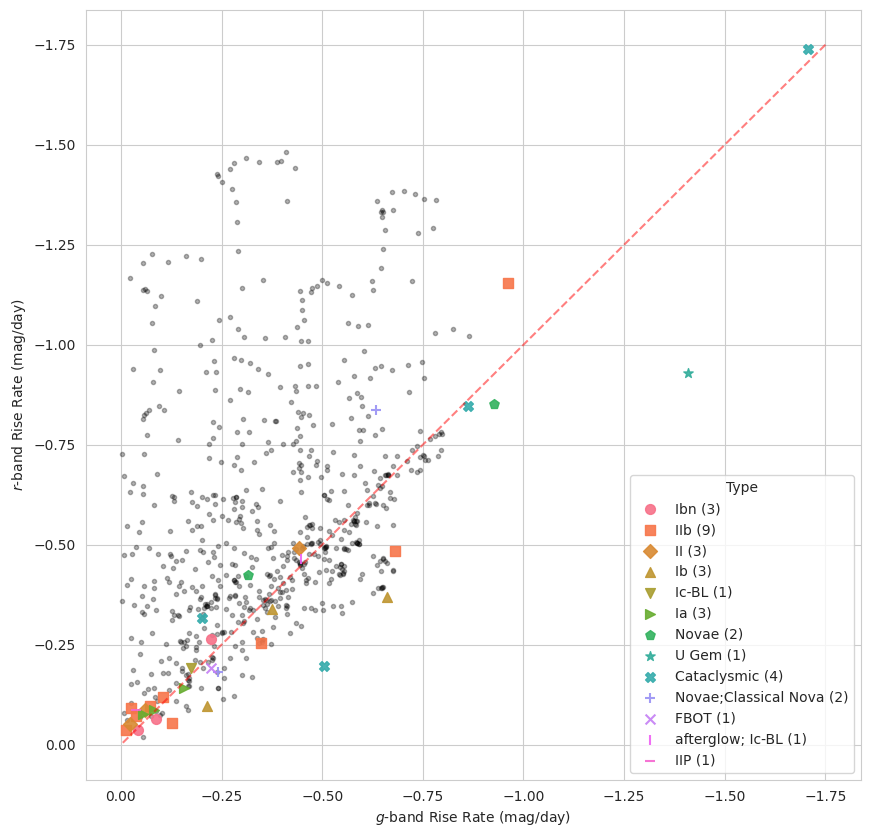

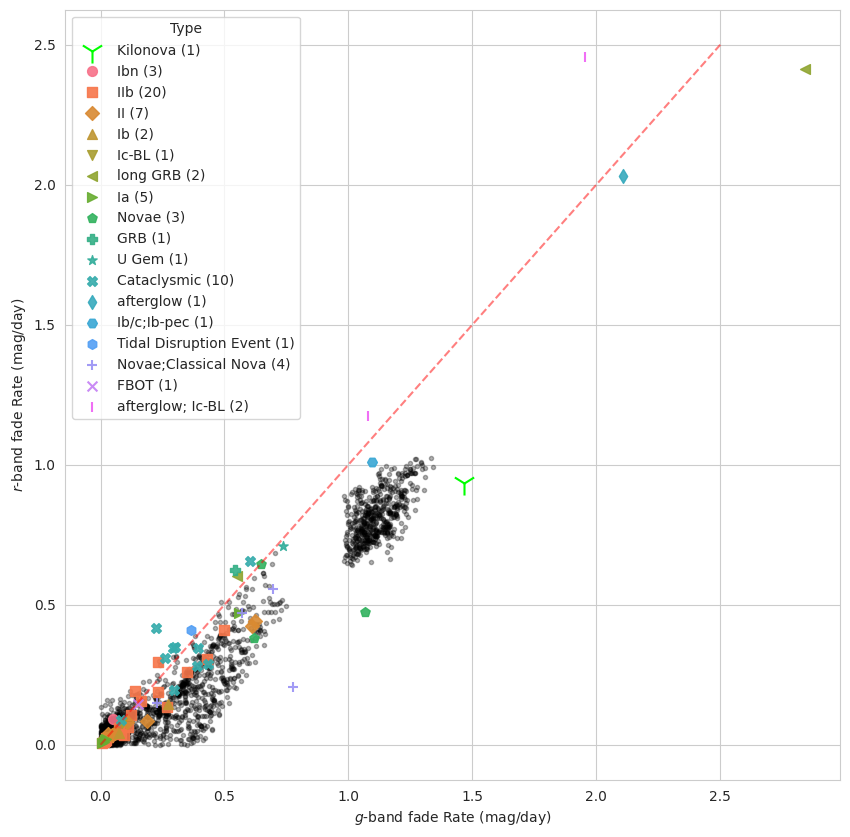

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
# ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfg_rise_rate'], df_2019[df_2019[f'ztfr_rise_rate'] > -1.75][f'ztfr_rise_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(-1.75,0,100), np.linspace(-1.75,0,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class[f'ztfg_rise_rate'], df_class[f'ztfr_rise_rate'],
                        color=type_style_dict[type_]['color'], marker=type_style_dict[type_]['marker'],
                            s=s_, alpha=a_, label=type_, zorder=z_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_rise_rate'].notnull()) & (df_rates['ztfr_rise_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylabel("$\it{r}$-band Rise Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band Rise Rate (mag/day)");
#plt.savefig('figures/ztfg_rise_rate_vs_ztfr_rise_rate.pdf', bbox_inches='tight')
ax.invert_xaxis(), ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10), 
                       sharex=True,sharey=True)
# ax.grid()
ax.scatter(df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfg_fade_rate'], df_2019[df_2019[f'ztfr_fade_rate'] > -1.75][f'ztfr_fade_rate'], alpha=0.3,color='k',marker='.')
ax.plot(np.linspace(0,2.5,100), np.linspace(0,2.5,100), color='r', linestyle='--',alpha=0.5)
for type_ in df_rates['type'].unique():
    df_class = df_rates[(df_rates['type'] == type_) & (df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]
    if len(df_class) > 0:
        s_ = type_style_dict[type_]['size']
        a_ = type_style_dict[type_]['alpha']
        c_ = type_style_dict[type_]['color']
        m_ = type_style_dict[type_]['marker']
        z_ = type_style_dict[type_]['zorder']
        ax.scatter(df_class[f'ztfg_fade_rate'], df_class[f'ztfr_fade_rate'],
                        color=c_, marker=m_, s=s_, alpha=a_, label=type_, zorder=z_)

class_counts_ztfg_ztfr = df_rates[(df_rates['ztfg_fade_rate'].notnull()) & (df_rates['ztfr_fade_rate'].notnull())]['type'].value_counts().to_dict()
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{label} ({class_counts_ztfg_ztfr[label]})' for label in labels if label in class_counts_ztfg_ztfr]
legend = ax.legend(handles, new_labels, title='Type')#, bbox_to_anchor=(1, 1), loc="upper left")
#ax.invert_xaxis(), ax.invert_yaxis()

ax.set_ylabel("$\it{r}$-band fade Rate (mag/day)"), ax.set_xlabel("$\it{g}$-band fade Rate (mag/day)");
plt.savefig('figures/ztfg_fade_rate_vs_ztfr_fade_rate.pdf', bbox_inches='tight') if savefigs else None

plt.show()

## Metric Distances Experiment

In [26]:
def metric_distance(object, model_data):
    '''
    Finds the average distance between an object and model data. 
    
    Args:
    object (tuple): tuple containing an object's two metrics (x,y)
    model_data (list): list of tuples containing the model data's metrics (x,y)
    
    Returns:
    distance (float): average distance between object and model_data
    '''
    distance_array = np.array([np.sqrt((object[0] - model[0])**2 + (object[1] - model[1])**2) for model in model_data])
    distance_array = distance_array[~np.isnan(distance_array)]
    # print(distance_array)
    distance = np.mean(distance_array)
    return distance


In [27]:
model_risepeak_list = list(zip(df_2019['ztfg_rise_rate'], df_2019['ztfg_peak_mag']))
objects_risepeak_list = list(zip(df_rates['ztfg_rise_rate'], df_rates['ztfg_peak_mag']))
# print(objects_risepeak_list)
# print(df_risepeak['obj_id'])
distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
for filt in ['ztfg', 'ztfr', 'ztfi']:
    model_risepeak_list = list(zip(df_2019[f'{filt}_rise_rate'], df_2019[f'{filt}_peak_mag']))
    objects_risepeak_list = list(zip(df_rates[f'{filt}_rise_rate'], df_rates[f'{filt}_peak_mag']))
    distance_risepeak = {obj: metric_distance(obj_data, model_risepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_risepeak_list)}
    df_rates[f'{filt}_risepeak_distance'] = distance_risepeak.values() 
    
    model_fadepeak_list = list(zip(df_2019[f'{filt}_fade_rate'], df_2019[f'{filt}_peak_mag']))
    objects_fadepeak_list = list(zip(df_rates[f'{filt}_fade_rate'], df_rates[f'{filt}_peak_mag']))
    distance_fadepeak = {obj: metric_distance(obj_data, model_fadepeak_list) for obj, obj_data in zip(df_rates.obj_id, objects_fadepeak_list)}
    df_rates[f'{filt}_fadepeak_distance'] = distance_fadepeak.values()

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-pac

<Axes: xlabel='ztfg_fadepeak_distance', ylabel='Count'>

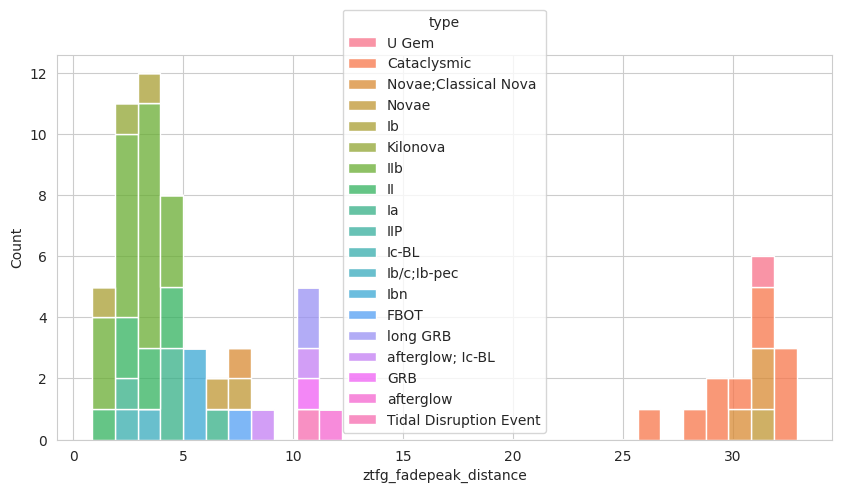

In [29]:
sns.set_palette('colorblind')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data=df_rates.sort_values('redshift'), x='ztfg_fadepeak_distance', hue='type', multiple='stack', ax=ax, bins=31)

((-0.01, 0.25), (-0.05, 35.0))

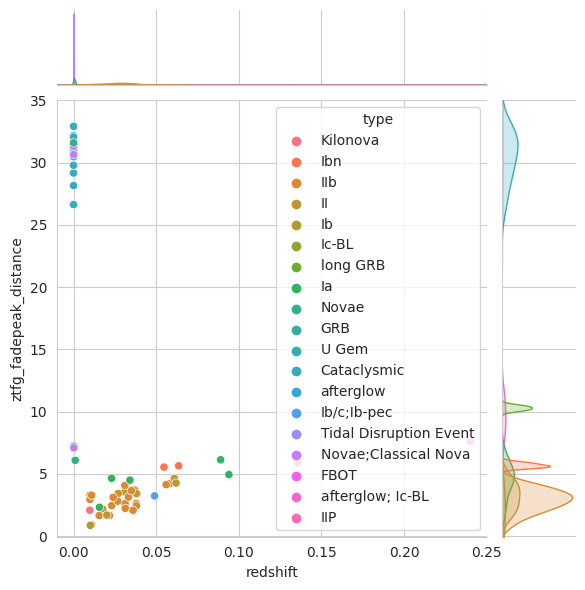

In [30]:
JG1 = sns.jointplot(data=df_rates, x='redshift', y='ztfg_fadepeak_distance', hue='type',markers='type')
JG1.ax_marg_x.set_xlim(-0.01,0.25), JG1.ax_marg_y.set_ylim(-0.05,35)
# JG1.ax_marg_x.set_xlim(-0.3,None), JG1.ax_marg_y.set_ylim(-1,None)

/tmp/ipykernel_323012/149681224.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


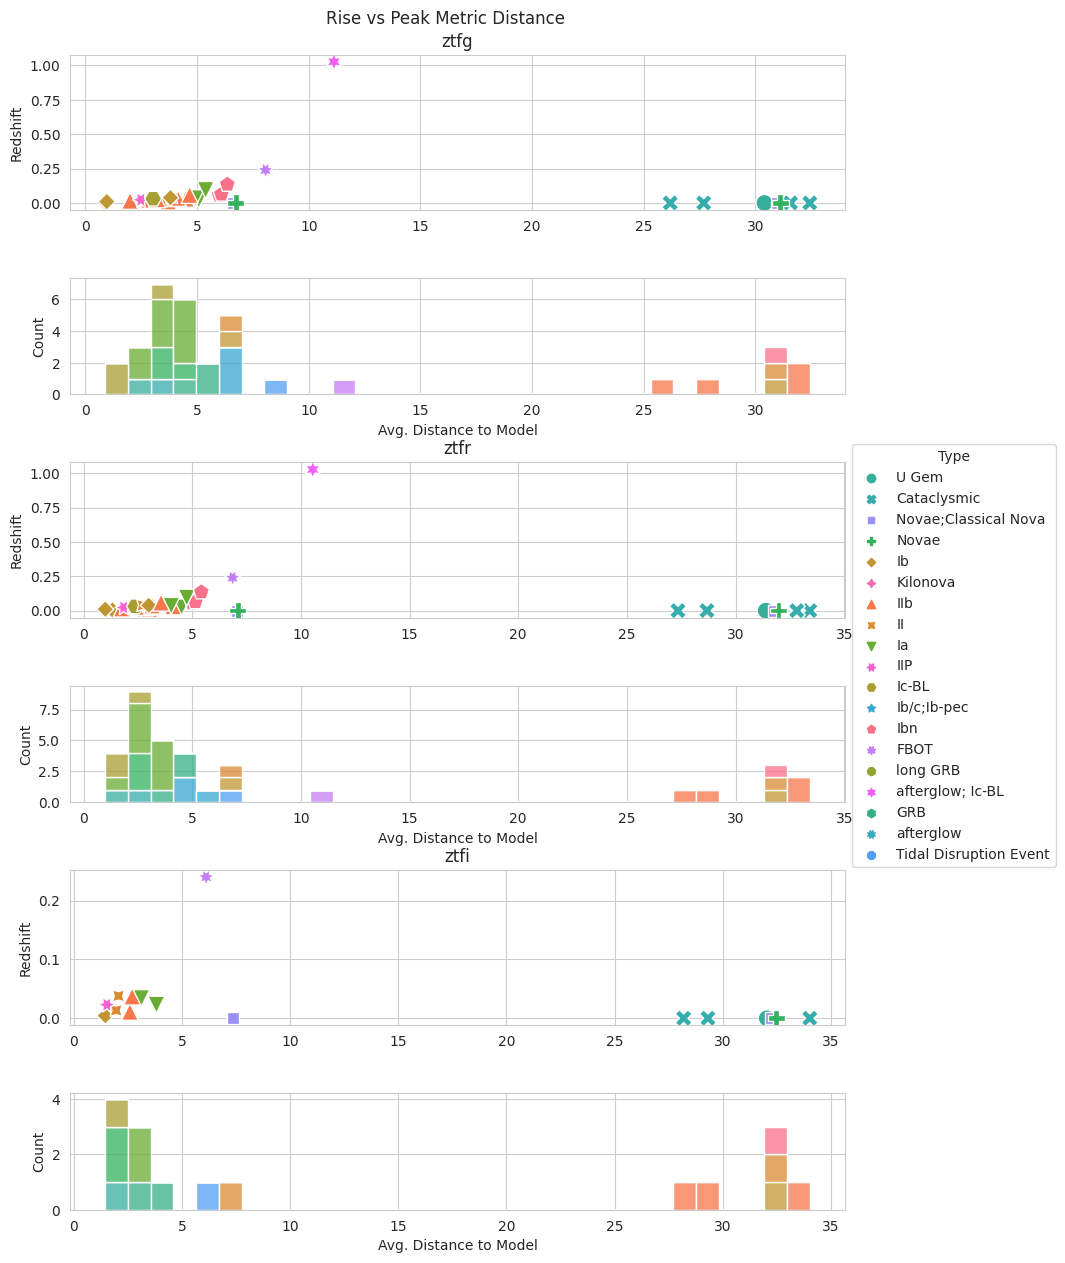

In [31]:
filters = ['ztfg', 'ztfr', 'ztfi'] 
y_column = 'redshift'
x_columns = {
    'ztfg': 'ztfg_risepeak_distance',
    'ztfr': 'ztfr_risepeak_distance',
    'ztfi': 'ztfi_risepeak_distance'
}

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

handles, labels = [], []

for i, filt in enumerate(filters):

    x_column = x_columns[filt]

    ax_scatter = fig.add_subplot(gs[i*2, 0])
    scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter, palette=colors_dict)
    ax_scatter.set_title(f'{filt}')
    ax_scatter.set_ylabel('Redshift')
    ax_scatter.set_xlabel(None)

    if i == 0:
        handles, labels = ax_scatter.get_legend_handles_labels()
    ax_scatter.legend_.remove()
    
    ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
    #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
    sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
    ax_hist.set_xlabel('Avg. Distance to Model')
    #ax_hist.set_ylabel('Count')

fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")
fig.suptitle('Rise vs Peak Metric Distance', y=0.91)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('figures/rise_vs_peak_metric_distance.pdf', bbox_inches='tight') if savefigs else None
plt.show()

/tmp/ipykernel_323012/46556144.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


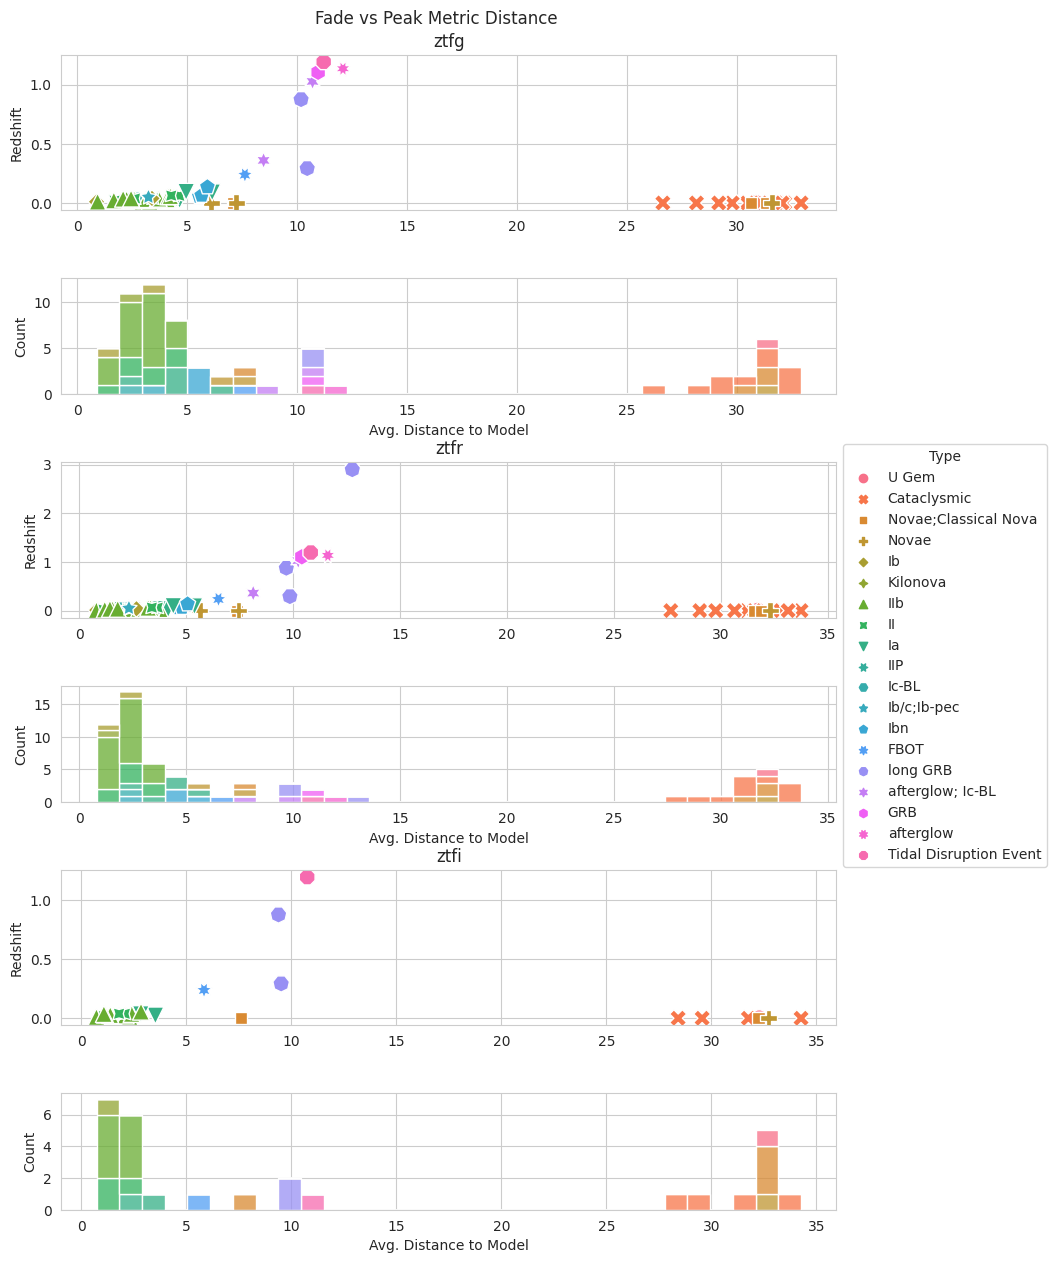

In [32]:
filters = ['ztfg', 'ztfr', 'ztfi'] 
y_column = 'redshift'
x_columns = {
    'ztfg': 'ztfg_fadepeak_distance',
    'ztfr': 'ztfr_fadepeak_distance',
    'ztfi': 'ztfi_fadepeak_distance'
}

fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(6, 1, height_ratios=[4,3] * 3, hspace=0.5)

handles, labels = [], []

for i, filt in enumerate(filters):

    x_column = x_columns[filt]

    ax_scatter = fig.add_subplot(gs[i*2, 0])
    scatter = sns.scatterplot(data=df_rates.sort_values('redshift'), x=x_column, y=y_column, hue='type', style='type', s=150, ax=ax_scatter)
    ax_scatter.set_title(f'{filt}')
    ax_scatter.set_ylabel('Redshift')
    ax_scatter.set_xlabel(None)

    if i == 0:
        handles, labels = ax_scatter.get_legend_handles_labels()
    ax_scatter.legend_.remove()
    
    ax_hist = fig.add_subplot(gs[i*2+1, 0], sharex=ax_scatter)
    #ax_hist.hist(df_rates[x_column], bins=30, color='gray', alpha=0.7)
    sns.histplot(data=df_rates.sort_values('redshift'), x=x_column, hue='type', multiple='stack', ax=ax_hist, bins=31,legend=False)
    ax_hist.set_xlabel('Avg. Distance to Model')
    #ax_hist.set_ylabel('Count')

fig.legend(handles=handles, labels=labels, title='Type', bbox_to_anchor=(0.9, 0.625), loc="upper left")

plt.tight_layout(rect=[0, 0, 0.85, 1])
fig.suptitle('Fade vs Peak Metric Distance', y=0.91)
plt.savefig('figures/fade_vs_peak_metric_distance.pdf', bbox_inches='tight') if savefigs else None
plt.show()